## Motif Analysis

### What I'm Trying to Do

I'm analyzing a dataset of synaptic connections between neurons.  
My goal is to compute **how often certain connectivity motifs appear**, compared to what I'd expect by chance.

But the dataset is incomplete — for many neuron pairs, I don’t know if there’s a connection or not (`has_synapse == NaN`).  
So I need to be careful to only count motifs where I actually have the necessary data.

---

### The Motif z-score (τ)

To quantify how "special" a motif is, I calculate a z-score, which I call **τ**.  
This tells me if a given motif is **more or less frequent than expected by chance**, assuming synapses are formed independently.

The formula I use is:

τ = (p_motif - p²) / σ²


- `p_motif` is the observed frequency of the motif.
- `p` is the overall connection probability.
- `σ² = p(1 - p)` is the variance under a Bernoulli model.

---

### Estimating p (Connection Probability)

To get the baseline connection probability `p`,  
I divide the number of observed synapses (`has_synapse == 1`)  
by the total number of measured neuron pairs (`has_synapse == 1 + has_synapse == 0`,  excluding NaNs).

---

### Counting Valid Motif Candidates

Since I don’t have full connectivity data, I must **filter which motifs I can test**.

For example:
- To count **reciprocal motifs**, I only include pairs (A, B) if I have both A→B and B→A measured.
- For **3-neuron motifs** (divergent, convergent, chain), I only consider triplets (A, B, C) where the two required connections were both measured.

This ensures that the **denominator of p_motif** only includes motifs I could have possibly observed.

---

### Counting Observed Motifs

I loop over the list of observed synapses and count:

- **Reciprocal motifs**: if both A→B and B→A exist.
- **Divergent motifs**: one neuron projecting to two.
- **Convergent motifs**: two neurons projecting to the same one.
- **Chain motifs**: A→B→C.

I also ensure that I avoid counting the same motif multiple times (e.g., by imposing a condition such as `pre1 < pre2`).

---

### Why I Do This

Since many connections are missing in the dataset (NaNs),  
I want my motif counts to be **based only on the data I actually have**.

By filtering the valid motif candidates this way,  
I avoid false negatives and ensure my **τ** scores are meaningful.

---



In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter


In [4]:
# Modify 'path' if it's necessary
data_size = 'small'
path=fr'C:\\Users\\macevedo\\Desktop\\IB\\cache\\database\\synphys_r2.1_{data_size}.sqlite'

In [18]:
plt.scatter(x=0, y=0)
plt.show()

In [5]:
con = sqlite3.connect(path)
cur = con.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

# take only the table that has information about the connectivity
df2 = pd.read_sql_query("SELECT * from "+ str(table_list[2])[2:-3], con)
df3 = pd.read_sql_query("SELECT * from "+ str(table_list[3])[2:-3], con)
df7 = pd.read_sql_query("SELECT * from "+ str(table_list[7])[2:-3], con)
df9 = pd.read_sql_query("SELECT * from "+ str(table_list[9])[2:-3], con)

# Obtener los experimentos en df2 que son de ratón
mouse_ids = df2[df2['species'] == 'mouse']['id']

# Obtener los experimentos en df3 que tienen target_region == VISp
visp_ids = df3[df3['target_region'] == 'VisP']['id']
print(visp_ids)
# Intersección de ambos conjuntos de experimentos
valid_exp_ids = set(mouse_ids).intersection(set(visp_ids))

# Filtrar df9 con esos experimentos válidos
df9 = df9[df9['experiment_id'].isin(mouse_ids)]


# # Unimos los dataframes con las columnas que te interesan
# df_merged = pd.merge(df9[['id', 'experiment_id', 'has_synapse', 'pre_cell_id', 'post_cell_id']],
#                      df7[['id', 'cell_class']],
#                      left_on='pre_cell_id', right_on='id')
# df_merged.rename(columns={'cell_class': 'pre_cell_class'}, inplace=True)

# # Seleccionamos y ordenamos las columnas deseadas
# df_result = df_merged[['experiment_id','pre_cell_id', 'post_cell_id', 'has_synapse', 'pre_cell_class']]
# df_result = df_result[df_result['pre_cell_class']!= 'mixed']

# # Merge adicional entre post_cell_id y id en df7
# df_result = pd.merge(df_result,
#                      df7[['id', 'cell_class']],
#                      left_on='post_cell_id', right_on='id',
#                      suffixes=('_pre', '_post'))

# # Filtramos los resultados para que los 'pre_cell_class' no sean 'mixed'
# df_result = df_result[df_result['pre_cell_class'] != 'mixed']

# # Si quieres cambiar el nombre de la columna 'cell_class_post' por ejemplo, puedes hacerlo de la siguiente manera:
# df_result.rename(columns={'cell_class': 'post_cell_class'}, inplace=True)


# df_result = df_result[['experiment_id','pre_cell_id', 'post_cell_id', 'has_synapse', 'pre_cell_class', 'post_cell_class']]
# df_clean = df_result.dropna(subset=['pre_cell_class', 'post_cell_class', 'has_synapse'])


0          1
1          2
2          3
3          4
4          5
        ... 
5053    5265
5054    5266
5055    5267
5056    5268
5057    5269
Name: id, Length: 4369, dtype: int64


In [6]:
df9_nonan = df9.dropna(subset=['has_synapse'])
print(len(df9_nonan['experiment_id'].unique()))


2492


In [7]:
import numpy as np

# Filtrar datos sin NaN en has_synapse
df9_nonan = df9.dropna(subset=['has_synapse'])

experimentos_con_3omas = 0  # Contador de experimentos con >=3 sinapsis
total_0 = 0
total_1 = 0

# Loop por experimento
for exp_id in df9_nonan['experiment_id'].unique():
    df_exp = df9_nonan[df9_nonan['experiment_id'] == exp_id]
    
    # Contar 0s y 1s en has_synapse
    count_0 = (df_exp['has_synapse'] == 0.0).sum()
    count_1 = (df_exp['has_synapse'] == 1.0).sum()
    
    print(f"Experiment {exp_id}:")
    print(f"  Has Synapse = 0.0 (no): {count_0}")
    print(f"  Has Synapse = 1.0 (yes): {count_1}")
    print()
    
    total_0 += count_0
    total_1 += count_1

    if count_1 >= 3:
        experimentos_con_3omas += 1

print("Resumen total:")
print(f"  Total de sinapsis con has_synapse = 0.0: {total_0}")
print(f"  Total de sinapsis con has_synapse = 1.0: {total_1}")
print(f"  Total de sinapsis medidas: {total_1+total_0}")
print(f"  Cantidad de experimentos con >=3 sinapsis (has_synapse = 1.0): {experimentos_con_3omas}")


Experiment 21:
  Has Synapse = 0.0 (no): 1
  Has Synapse = 1.0 (yes): 1

Experiment 25:
  Has Synapse = 0.0 (no): 42
  Has Synapse = 1.0 (yes): 0

Experiment 26:
  Has Synapse = 0.0 (no): 20
  Has Synapse = 1.0 (yes): 0

Experiment 27:
  Has Synapse = 0.0 (no): 56
  Has Synapse = 1.0 (yes): 0

Experiment 28:
  Has Synapse = 0.0 (no): 56
  Has Synapse = 1.0 (yes): 0

Experiment 33:
  Has Synapse = 0.0 (no): 6
  Has Synapse = 1.0 (yes): 0

Experiment 35:
  Has Synapse = 0.0 (no): 12
  Has Synapse = 1.0 (yes): 0

Experiment 36:
  Has Synapse = 0.0 (no): 56
  Has Synapse = 1.0 (yes): 0

Experiment 38:
  Has Synapse = 0.0 (no): 56
  Has Synapse = 1.0 (yes): 0

Experiment 37:
  Has Synapse = 0.0 (no): 56
  Has Synapse = 1.0 (yes): 0

Experiment 39:
  Has Synapse = 0.0 (no): 56
  Has Synapse = 1.0 (yes): 0

Experiment 41:
  Has Synapse = 0.0 (no): 56
  Has Synapse = 1.0 (yes): 0

Experiment 40:
  Has Synapse = 0.0 (no): 56
  Has Synapse = 1.0 (yes): 0

Experiment 44:
  Has Synapse = 0.0 (no):

In [10]:
import matplotlib.pyplot as plt
import numpy as np

experimentos_completos = []

# Encontrar experimentos con todas las sinapsis posibles medidas
for exp_id in df9_nonan['experiment_id'].unique():
    df_exp = df9_nonan[df9_nonan['experiment_id'] == exp_id]

    pre_ids = df_exp['pre_cell_id'].unique()
    post_ids = df_exp['post_cell_id'].unique()
    neuronas_total = np.unique(np.concatenate((pre_ids, post_ids)))
    n = len(neuronas_total)

    sinapsis_posibles = n * (n - 1)

    sinapsis_measures = df_exp[df_exp['pre_cell_id'] != df_exp['post_cell_id']]
    sinapsis_unicas = sinapsis_measures[['pre_cell_id', 'post_cell_id']].drop_duplicates()
    
    if len(sinapsis_unicas) == sinapsis_posibles:
        experimentos_completos.append((exp_id, df_exp, neuronas_total))

# Graficar los primeros 100 experimentos válidos
n_max = min(100, len(experimentos_completos))
n_cols = 10
n_rows = int(np.ceil(n_max / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
axs = axs.flatten()

for i, (exp_id, df_exp, neuronas_total) in enumerate(experimentos_completos[:n_max]):
    n = len(neuronas_total)
    idx_map = {neuron: idx for idx, neuron in enumerate(neuronas_total)}
    adj = np.zeros((n, n))

    for _, row in df_exp.iterrows():
        pre = row['pre_cell_id']
        post = row['post_cell_id']
        if pre != post:
            i_pre = idx_map[pre]
            i_post = idx_map[post]
            adj[i_pre, i_post] = 1 if row['has_synapse'] == 1.0 else 0

    ax = axs[i]
    im = ax.imshow(adj, cmap='Greys', interpolation='none')
    
    # Agregar líneas para contornos
    ax.set_xticks(np.arange(-.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n, 1), minor=True)
    ax.grid(which="minor", color='black', linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(f"Exp {exp_id}\n{n} neuronas", fontsize=8)


# Ocultar ejes sobrantes
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()



In [9]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from itertools import combinations
from collections import Counter
matplotlib.use('TkAgg') 
#CARGO TABLA
data_size = 'medium'
path=fr'C:\\Users\\macevedo\\Desktop\\IB\\cache\\database\\synphys_r2.1_{data_size}.sqlite'
con = sqlite3.connect(path)
cur = con.cursor()

table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
df9 = pd.read_sql_query("SELECT * from "+ str(table_list[9])[2:-3], con)
# Eliminar filas con NaN en 'has_synapse'
df9 = df9.dropna(subset=['has_synapse'])


## CUENTO PATRONES ##

def count_reciprocal(df):
    # Mapea si existe sinapsis en cada dirección
    connectivity = set(map(tuple, df[['pre_cell_id','post_cell_id']].values))
    rec = 0

    # Itera sobre combinaciones no ordenadas de pares de neuronas (toma combinaciones, entonces cuenta los pares de conexiones una sola vez)
    neurons = df['pre_cell_id'].unique()
    for a, b in combinations(neurons, 2):
        # ¿Existe A→B y B→A?
        if (a,b) in connectivity and (b,a) in connectivity:
            rec += 1

    return rec

def count_divergent(df):
    div = 0
    # Para cada presináptico, mira sus posts y elige pares de posts
    for pre, subdf in df.groupby('pre_cell_id'):
        posts = subdf['post_cell_id'].unique()
        for post1, post2 in combinations(posts, 2):
            # Asegura que sean tres neuronas distintas
            if post1 == post2 or post1 == pre or post2 == pre:
                continue
            div += 1

    return div

def count_convergent(df):
    con = 0

    # Para cada postsináptico, mira sus pres y elige pares de pres
    for post, subdf in df.groupby('post_cell_id'):
        pres = subdf['pre_cell_id'].unique()
        for pre1, pre2 in combinations(pres, 2):
            if pre1 == post or pre2 == post:
                continue
            con += 1

    return con

def count_chain(df):

    chn = 0

    # Gamma es nodo intermedio: aparece como post en una conexión y pre en otra
    for gamma in set(df['pre_cell_id']).intersection(df['post_cell_id']):
        ins  = df[df['post_cell_id']==gamma]  # conexiones pre→gamma
        outs = df[df['pre_cell_id']==gamma]   # conexiones gamma→post
        pres = ins['pre_cell_id'].unique()
        posts = outs['post_cell_id'].unique()
        # Combina cada pre con cada post
        for pre, post in ((p, q) for p in pres for q in posts):
            if pre in (gamma, post) or post in (gamma, pre):
                continue
            chn += 1

    return chn

### CALCULO MOTIFS ###
# Devuelve np.nan si el denominador es cero
def safe_divide(n, d):
    return n / d if d != 0 else np.nan

def compute_tau(count_motif, count_possible, sigma2, p):
    p_motif = safe_divide(count_motif,count_possible)

    return safe_divide((p_motif-p**2),sigma2)

def compute_motifs(df):
    # para calcular los posibles motivos tomamos el data frame donde la columna 'has_synapse' toma valores 0 o 1
    # es decir, se realizó la medición y se determinó si hay ('has_synapse' = 1) o no hay ('has_synapse' = 0) sinapsis.
    possible_rec = count_reciprocal(df)
    possible_div = count_divergent(df)
    possible_con = count_convergent(df)
    possible_chn = count_chain(df)

    # Ahora, para calcular la cantidad de motivos que efectivamente están presentes en los datos,
    # usamos el subconjunto de conexiones donde sí se detectó sinapsis ('has_synapse' = 1).
    # utilizamos la misma funciones que antes.

    df_syn = df[df['has_synapse'] == 1]

    rec_count = count_reciprocal(df_syn)
    div_count = count_divergent(df_syn)
    con_count = count_convergent(df_syn)
    chn_count = count_chain(df_syn)


    if len(df_syn) == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    
    p = len(df_syn) / len(df)
    
    sigma2 = p * (1 - p)

    tau_rec = compute_tau(rec_count, possible_rec, sigma2, p)
    tau_div = compute_tau(div_count, possible_div, sigma2, p)
    tau_con = compute_tau(con_count, possible_con, sigma2, p)
    tau_chn = compute_tau(chn_count, possible_chn, sigma2, p)
   

    return tau_rec, tau_div, tau_con, tau_chn

####### BOOTSTRAP (código Germán) #######
motifs_data = {
    'experiment_id': [],
    'motivo_rec': [],
    'motivo_div': [],
    'motivo_con': [],
    'motivo_chn': []
}

nboot=10
df9 = df9.dropna(subset=['has_synapse'])
iexp=df9['experiment_id'].unique()


    


for iboot in range(nboot):
    iexp_i=iexp[np.random.choice(len(iexp), size=int(len(iexp)*0.1), replace=False)]
    print(iboot)
    av_rec=[]
    av_div=[]
    av_con=[]
    av_chn=[]
    for i in iexp_i:
 
        if len(df9[df9['experiment_id'] == i]) < 3:
            continue
    
        df_exp = df9[df9['experiment_id'] == i]


        # Obtener neuronas únicas involucradas como pre o post
        pre_ids = df_exp['pre_cell_id'].unique()
        post_ids = df_exp['post_cell_id'].unique()
        neuronas_total = np.unique(np.concatenate((pre_ids, post_ids)))
        n = len(neuronas_total)

        # Calcular número esperado de sinapsis posibles (sin autoconexiones)
        sinapsis_posibles = n * (n - 1)

        # Obtener todas las combinaciones medidas reales (sin duplicados ni autoconexiones)
        sinapsis_measures = df_exp[df_exp['pre_cell_id'] != df_exp['post_cell_id']]
        sinapsis_unicas = sinapsis_measures[['pre_cell_id', 'post_cell_id']].drop_duplicates()

        # Filtrar solo si todas las sinapsis posibles están presentes
        if len(sinapsis_unicas) != sinapsis_posibles:
            continue
        
        motivo_rec, motivo_div, motivo_con, motivo_chn = compute_motifs(df_exp)
       
        av_rec.append(motivo_rec)
        av_div.append(motivo_div)
        av_con.append(motivo_con)
        av_chn.append(motivo_chn)
    
    av_rec=np.nanmean(np.array(av_rec))
    av_div=np.nanmean(np.array(av_div))
    av_con=np.nanmean(np.array(av_con))
    av_chn=np.nanmean(np.array(av_chn))
    
    motifs_data['experiment_id'].append(iboot) 
    motifs_data['motivo_rec'].append(av_rec)
    motifs_data['motivo_div'].append(av_div)
    motifs_data['motivo_con'].append(av_con)
    motifs_data['motivo_chn'].append(av_chn)

df_motifs = pd.DataFrame(motifs_data)
print(df_motifs)
plt.figure(figsize=(8, 5)) 
for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
    datos = df_motifs[motif].dropna()
    print(f"{motif}: {len(datos)} valores")

    if len(datos) == 0:
        print(f"No hay datos para {motif}, se salta el gráfico.")
        continue

    plt.figure(figsize=(6, 4))
    plt.hist(datos, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histograma de {motif}")
    plt.xlabel('Valor del motivo')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



0
1
2
3
4
5
6
7
8
9
   experiment_id  motivo_rec  motivo_div  motivo_con  motivo_chn
0              0    0.116287   -0.038758   -0.038199   -0.072478
1              1    0.142793   -0.050378   -0.052724   -0.063651
2              2    0.113768   -0.044000   -0.058732   -0.081686
3              3    0.111607   -0.057203   -0.079687   -0.073559
4              4    0.125668   -0.052325   -0.056416   -0.052790
5              5    0.130549   -0.045290   -0.076868   -0.084970
6              6    0.097542   -0.026293   -0.068170   -0.065753
7              7    0.124752   -0.051571   -0.087209   -0.071203
8              8    0.146825   -0.043622   -0.082968   -0.078565
9              9    0.125815   -0.060550   -0.095309   -0.072375
motivo_rec: 10 valores
motivo_div: 10 valores
motivo_con: 10 valores
motivo_chn: 10 valores


In [ ]:
from itertools import permutations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def safe_divide(n, d):
    return n / d if d != 0 else np.nan

def compute_tau(p_motif, p_conn):
    sigma2 = p_conn*(1-p_conn)
    return safe_divide((p_motif-p_conn**2),sigma2)


def probabilities(df):
    
    n_syn = len(df)
    n_syn_ex = len(df[df["pre_cell_class"]=='in'])
    n_syn_inh = len(df[df["pre_cell_class"]=='ex'])

    p_ex = n_syn_ex/(n_syn_ex+n_syn_inh)
    p_inh = n_syn_inh/(n_syn_ex+n_syn_inh)

    n_IE = len(df[(df["pre_cell_class"] == 'ex') & (df["post_cell_class"] == 'in')])
    n_EI = len(df[(df["pre_cell_class"] == 'in') & (df["post_cell_class"] == 'ex')])
    n_II = len(df[(df["pre_cell_class"] == 'in') & (df["post_cell_class"] == 'ex')])
    n_EE = len(df[(df["pre_cell_class"] == 'ex') & (df["post_cell_class"] == 'ex')])

    
    n_datos = n_IE + n_EI + n_II + n_EE
    if n_datos >0:
        p_IE = n_IE/n_datos
        p_EI = n_EI/n_datos
        p_EE = n_EE/n_datos
        p_II = n_II/n_datos
        
        return p_ex, p_inh, p_IE, p_EI, p_EE, p_II
    else:
        return 0,0,0,0,0,0



def count_reciprocal(df):

    connections = [(pre, post, syn_type)
                   for syn_type, pre, post in df[['pre_cell_class', 'pre_cell_id', 'post_cell_id']].values]
    
    count_rec_EE, count_rec_II,count_rec_IE = 0, 0, 0

    checked = set()

    for (pre, post,type1) in connections:
        
        if any(p == post and o == pre for p, o, _,  in connections) and (post, pre) not in checked and pre != post:
            type2 = df.loc[(df['pre_cell_id'] == post) & (df['post_cell_id'] == pre), 'pre_cell_class'].iloc[0]
            if type1 == 'in' and type2 == 'in':
                count_rec_II +=1
            if (type1=='ex' and type2=='in') or (type1 == 'in' and type2 =='ex'):
                count_rec_IE +=1
            if type1 == 'ex' and type2 == 'ex':
                count_rec_EE += 1

            checked.add((pre, post))
            
    return count_rec_II, count_rec_IE, count_rec_EE




def compute_motifs_by_type(df):
    
    df_only_existing_synapses = df[df['has_synapse']==1]

    possible_rec_II, possible_rec_IE, possible_rec_EE = count_reciprocal(df)
    existing_rec_II, existing_rec_IE, existing_rec_EE = count_reciprocal(df_only_existing_synapses)
    
    p_ex, p_inh, p_IE, p_EI, p_EE, p_II = probabilities(df)

    p_rec_II = safe_divide(existing_rec_II, possible_rec_II)
    p_rec_IE = safe_divide(existing_rec_IE, possible_rec_IE)
    p_rec_EE = safe_divide(existing_rec_EE, possible_rec_EE)

    tau_rec_II = compute_tau(p_rec_II, p_II)
    return tau_rec_II


# Filtramos datos válidos
df = df_result.dropna(subset=['has_synapse'])

# Inicializamos un diccionario para guardar τs por motivo y tipo de sinapsis
motifs_by_type_data = []

tau_rec_II = []
tau_rec_EE = []
tau_rec_EI = []


for i in df['experiment_id'].unique():
    
    df_exp = df[df['experiment_id'] == i]
    if len(df_exp) < 3:
        continue
    
    II =  compute_motifs_by_type(df_exp)
    tau_rec_II.append(II)

    


ZeroDivisionError: division by zero

(array([638.,   1.,  16.,   0.,   1.,   0.,   7.,   2.,   1.,   1.]),
 array([-0.5,  0.2,  0.9,  1.6,  2.3,  3. ,  3.7,  4.4,  5.1,  5.8,  6.5]),
 <BarContainer object of 10 artists>)

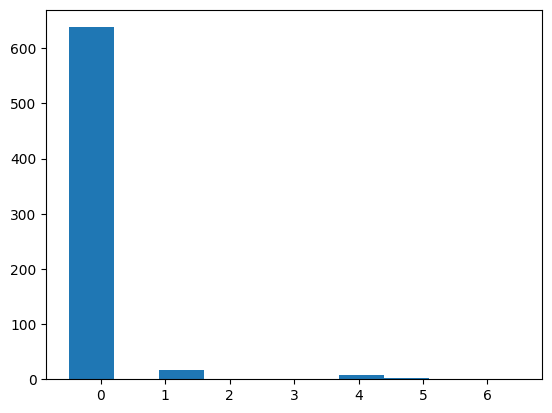

In [ ]:
plt.hist(tau_rec_II)

In [ ]:
    # print("Conexiones mapeadas:", connectivity)  # Esto debería mostrar las conexiones después del mapeo
    # # Set de neuronas y pares medidos
    # measured_set = set(connectivity.keys())
    #neurons = set(df['pre_cell_id']).union(set(df['post_cell_id']))

    # # # --- MOTIVO RECÍPROCO ---
    # possible_rec_EE, possible_rec_IE, possible_rec_II = count_possible_reciprocal(df)
    
    # count_rec_EE, count_rec_II,count_rec_IE = 0, 0, 0
    # checked = set()

    # for (pre, post,type1) in synaptic_connections:
        
    #     if any(p == post and o == pre for p, o, _,  in synaptic_connections) and (post, pre) not in checked and pre != post:
    #         type2 = df.loc[(df['pre_cell_id'] == post) & (df['post_cell_id'] == pre), 'synapse_type'].iloc[0]
    #         if type1 == 'in' and type2 == 'in':
    #             count_rec_II +=1
    #         if (type1=='ex' and type2=='in') or (type1 == 'in' and type2 =='ex'):
    #             count_rec_IE +=1
    #         if type1 == 'ex' and type2 == 'ex':
    #             count_rec_EE += 1

    #         checked.add((pre, post))
    # return count_rec_II/possible_rec_II, count_rec_IE/possible_rec_IE, count_rec_EE/possible_rec_EE
   


    # # --- MOTIVOS TERNARIOS ---
    # div_type_counts = Counter()
    # con_type_counts = Counter()
    # chn_type_counts = Counter()

    # # Posibles motivos
    # possible_triplets_div = count_possible_triplets(df, 'divergent')
    # possible_triplets_con = count_possible_triplets(df, 'convergent')
    # possible_triplets_chn = count_possible_triplets(df, 'chain')

    # for a, b, c in permutations(neurons, 3):
    #     # Divergente: A → B y A → C
    #     if (a, b) in connectivity and (a, c) in connectivity:
    #         t1 = connectivity[(a, b)]
    #         t2 = connectivity[(a, c)]
    #         div_type_counts[(t1, t2)] += 1

    #     # Convergente: B → A y C → A
    #     if (b, a) in connectivity and (c, a) in connectivity:
    #         t1 = connectivity[(b, a)]
    #         t2 = connectivity[(c, a)]
    #         con_type_counts[(t1, t2)] += 1

    #     # Cadena: A → B → C
    #     if (a, b) in connectivity and (b, c) in connectivity:
    #         t1 = connectivity[(a, b)]
    #         t2 = connectivity[(b, c)]
    #         chn_type_counts[(t1, t2)] += 1

    # # --- CÁLCULO DE TAUS ---
    # def compute_tau_for_motif(counts, possible, motif_name):
    #     taus = {}
    #     for types, count in counts.items():
    #         tau = compute_tau(count, possible, sigma2, p)
    #         taus[types] = tau
    #         print(f"{motif_name} {types[0]}–{types[1]}: {count}/{possible} → τ = {tau:.3f}")
    #     return taus

    # taus = {
    #     'reciprocal': compute_tau_for_motif(rec_type_counts, possible_rec, "Recíproco"),
    #     'divergent': compute_tau_for_motif(div_type_counts, possible_triplets_div, "Divergente"),
    #     'convergent': compute_tau_for_motif(con_type_counts, possible_triplets_con, "Convergente"),
    #     'chain': compute_tau_for_motif(chn_type_counts, possible_triplets_chn, "Cadena")
    # }

    # return taus

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def count_possible_triplets(df, motif_type='divergent'):
    measured_set = set(zip(df['pre_cell_id'], df['post_cell_id']))
    neurons = set(df['pre_cell_id']).union(set(df['post_cell_id']))
    possible_triplets = 0

    for a in neurons:
        for b in neurons:
            for c in neurons:
                if len({a, b, c}) < 3:
                    continue

                if motif_type == 'divergent' and (a, b) in measured_set and (a, c) in measured_set:
                    possible_triplets += 1

                elif motif_type == 'convergent' and (b, a) in measured_set and (c, a) in measured_set:
                    possible_triplets += 1

                elif motif_type == 'chain' and (a, b) in measured_set and (b, c) in measured_set:
                    possible_triplets += 1

    return possible_triplets

# Filtramos datos válidos
df = df_result.dropna(subset=['has_synapse'])

# Inicializamos un diccionario para guardar τs por motivo y tipo de sinapsis
motifs_by_type_data = []

tau_rec_II = []
tau_rec_EE = []
tau_rec_EI = []


for i in df['experiment_id'].unique():
    
    df_exp = df[df['experiment_id'] == i]
    print(df_exp)
    if len(df_exp) < 3:

        continue
    II, EE, EI =  compute_motifs_by_type(df_exp)
    tau_rec_II.append(II)
    tau_rec_EE.append(EE)
    tau_rec_EI.append(EI)
    #taus = compute_motifs_by_type(df_exp)


    # for motif_type, tau_dict in taus.items():
    #     for syn_type, tau_val in tau_dict.items():
    #         motifs_by_type_data.append({
    #             'experiment_id': i,
    #             'motif': motif_type,
    #             'synapse_type': f"{syn_type[0][0].upper()}{syn_type[1][0].upper()}",
    #             'tau': tau_val
    #         })

print(np.nanmean(tau_rec_II), np.nanmean(tau_rec_EI), np.nanmean(tau_rec_EE))
plt.hist(tau_rec_II, bins=20)
# Convertimos a DataFrame
df_motifs_by_type = pd.DataFrame(motifs_by_type_data)

plt.figure(figsize=(12, 8))

motif_types = ['reciprocal', 'divergent', 'convergent', 'chain']
syn_types = ['EE', 'EI', 'IE', 'II']

# for i, motif in enumerate(motif_types):
#     plt.subplot(2, 2, i + 1)
#     for syn in syn_types:

#         vals = df_motifs_by_type[(df_motifs_by_type['motif'] == motif) &
#                                  (df_motifs_by_type['synapse_type'] == syn)]['tau']
#         if len(vals) > 0:
#             plt.hist(vals, bins=10, alpha=0.6, label=syn)
#     plt.title(motif.capitalize())
#     plt.xlabel('Tau')
#     plt.ylabel('Frecuencia')
#     plt.legend()

# plt.tight_layout()
# plt.show()





     experiment_id  pre_cell_id  post_cell_id  has_synapse pre_cell_class  \
876             21          141           144          1.0             in   
903             21          144           141          0.0           None   

      id post_cell_class  
876  144            None  
903  141              in  
      experiment_id  pre_cell_id  post_cell_id  has_synapse pre_cell_class  \
1020             25          157           158          0.0           None   
1021             25          157           159          0.0           None   
1022             25          157           160          0.0           None   
1023             25          157           161          0.0           None   
1024             25          157           162          0.0           None   
1025             25          157           163          0.0           None   
1026             25          158           157          0.0             in   
1027             25          158           159          0.0    

KeyError: "['cell_class'] not in index"

In [8]:
import os

data_size = 'small'
path = fr'C:\\Users\\macevedo\\Desktop\\IB\\cache\\database\\synphys_r2.1_{data_size}.sqlite'

# Obtener el tamaño en bytes
file_size_bytes = os.path.getsize(path)

# Convertir a MB
file_size_mb = file_size_bytes / (1024 * 1024)

print(f"El archivo pesa aproximadamente {file_size_mb:.2f} MB")


El archivo pesa aproximadamente 168.58 MB


In [ ]:
def bootstrap_mean_std(data, n_bootstrap=1000, frac=0.8):
    means = []
    n_samples = int(len(data) * frac)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n_samples, replace=True)
        means.append(np.mean(sample))
    return np.mean(means), np.std(means)


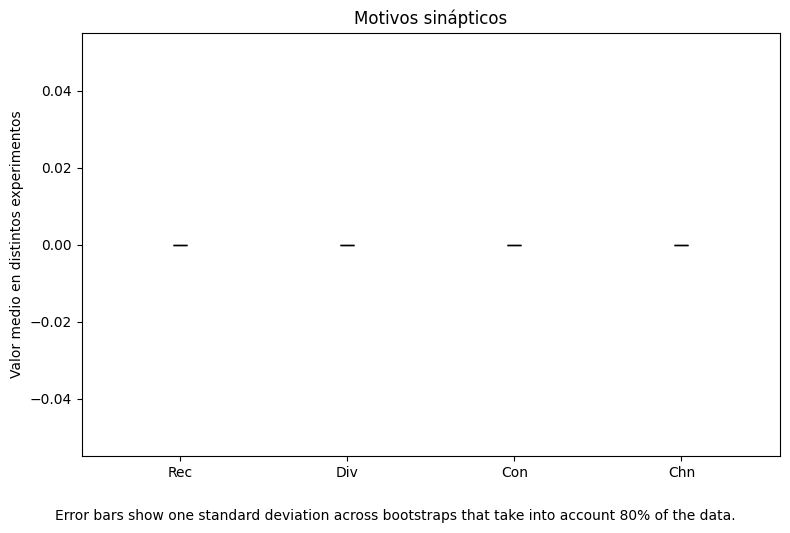

In [ ]:
plt.figure(figsize=(8, 5))

x_labels = ['Rec', 'Div', 'Con', 'Chn']
x_pos = np.arange(len(x_labels))
means = []
errors = []

for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
    mean, std = bootstrap_mean_std(df_motifs[motif].values)
    means.append(mean)
    errors.append(std)

plt.bar(x_pos, means, yerr=errors, capsize=5, alpha=0.7)
plt.xticks(x_pos, x_labels)
plt.ylabel('Valor medio en distintos experimentos')
plt.title('Motivos sinápticos')

# Explicación del error
plt.figtext(0.5, -0.05, 'Error bars show one standard deviation across bootstraps that take into account 80% of the data.',
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()


Motivos observados:
Recíproco: 0 / 28
Divergente: 0 / 336
Convergente: 0 / 336
Cadena: 0 / 336
Motivos observados:
Recíproco: 0 / 28
Divergente: 0 / 336
Convergente: 0 / 336
Cadena: 0 / 336
Motivos observados:
Recíproco: 4 / 15
Divergente: 4 / 120
Convergente: 12 / 120
Cadena: 7 / 120
Motivos observados:
Recíproco: 0 / 28
Divergente: 0 / 336
Convergente: 0 / 336
Cadena: 0 / 336
Motivos observados:
Recíproco: 0 / 28
Divergente: 0 / 336
Convergente: 0 / 336
Cadena: 0 / 336
Motivos observados:
Recíproco: 0 / 28
Divergente: 0 / 336
Convergente: 2 / 336
Cadena: 0 / 336
Motivos observados:
Recíproco: 0 / 28
Divergente: 0 / 336
Convergente: 0 / 336
Cadena: 0 / 336
Motivos observados:
Recíproco: 0 / 6
Divergente: 0 / 24
Convergente: 0 / 24
Cadena: 0 / 24
Motivos observados:
Recíproco: 0 / 28
Divergente: 0 / 336
Convergente: 0 / 336
Cadena: 0 / 336
Motivos observados:
Recíproco: 0 / 28
Divergente: 0 / 336
Convergente: 0 / 336
Cadena: 0 / 336
Motivos observados:
Recíproco: 0 / 6
Divergente: 0 / 

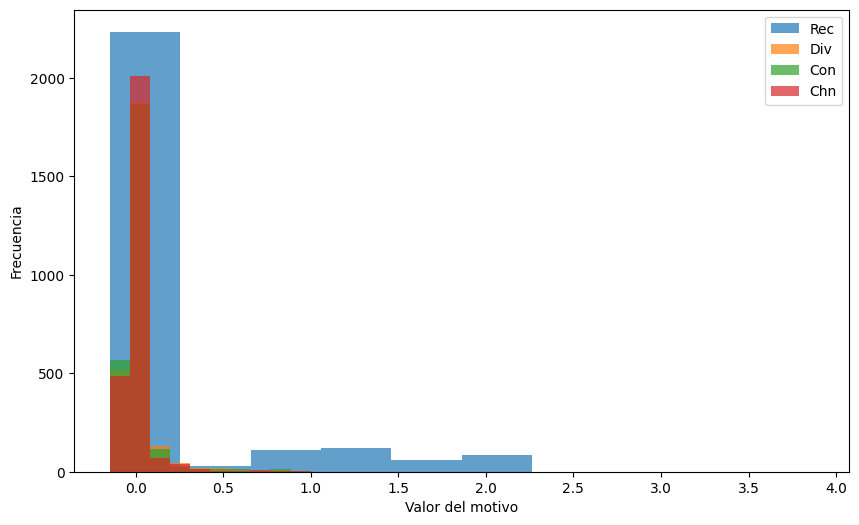

Text(0, 0.5, 'Valor medio en distintos experimentos')

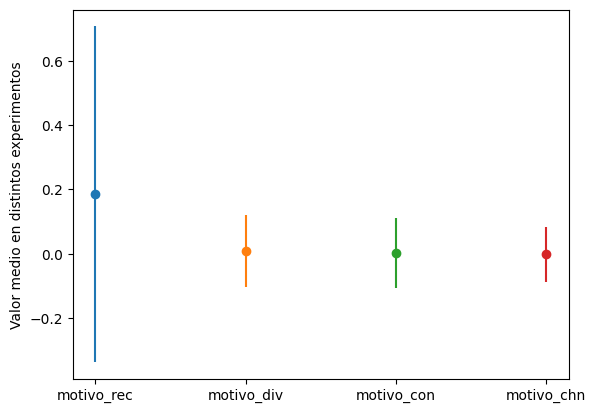

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Modify 'path' if it's necessary
data_size = 'medium'
path=fr'C:\\Users\\macevedo\\Desktop\\IB\\cache\\database\\synphys_r2.1_{data_size}.sqlite'

con = sqlite3.connect(path)
cur = con.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

# take only the table that has information about the connectivity
df9 = pd.read_sql_query("SELECT * from "+ str(table_list[9])[2:-3], con)

def compute_tau(count_motif, count_possible, sigma2, p):
    p_motif = count_motif/count_possible

    return ((p_motif-p**2)/sigma2)

def count_possible_reciprocal(df):
    # ACA SI YA CONTE EL PAR A-> <-B, no cuento luego B-> <-A
    synaptic_connections = df[df['has_synapse'] == 1][['pre_cell_id', 'post_cell_id']].values
    connectivity = {(pre, post): 1 for pre, post in synaptic_connections}
    rec_count = 0

    for pre1, post1 in synaptic_connections:
        if (post1, pre1) in connectivity:
            rec_count += 1

    return rec_count

def count_possible_triplets(df, motif_type='divergent'):
    measured_set = set(zip(df['pre_cell_id'], df['post_cell_id']))
    neurons = set(df['pre_cell_id']).union(set(df['post_cell_id']))
    possible_triplets = 0

    for a in neurons:
        for b in neurons:
            for c in neurons:
                if len({a, b, c}) < 3:
                    continue

                if motif_type == 'divergent' and (a, b) in measured_set and (a, c) in measured_set:
                    possible_triplets += 1

                elif motif_type == 'convergent' and (b, a) in measured_set and (c, a) in measured_set:
                    possible_triplets += 1

                elif motif_type == 'chain' and (a, b) in measured_set and (b, c) in measured_set:
                    possible_triplets += 1

    return possible_triplets

def compute_motifs(df):

    synaptic_connections = df[df['has_synapse'] == 1][['pre_cell_id', 'post_cell_id']].values
    num_synapses = len(synaptic_connections)
    num_measured_pairs = len(df)

    p = num_synapses / num_measured_pairs
    if p == 0:
        return (0, 0, 0, 0)

    sigma2 = p * (1 - p)

    connectivity = {(pre, post): 1 for pre, post in synaptic_connections}

    possible_rec = count_possible_reciprocal(df)
    possible_triplets_div = count_possible_triplets(df, 'divergent')
    possible_triplets_con = count_possible_triplets(df, 'convergent')
    possible_triplets_chn = count_possible_triplets(df, 'chain')

    rec_count = div_count = con_count = chn_count = 0

    for pre1, post1 in synaptic_connections:
            # ACA SI YA CONTE EL PAR A-> <-B, también cuento luego B-> <-A
            if (post1, pre1) in connectivity:
                rec_count += 1
            for pre2, post2 in synaptic_connections:
                if pre1 == pre2 and post1 == post2:
                    continue
                if pre1 == pre2 and post1 != post2:
                    div_count += 1
                if post1 == post2 and pre1 != pre2:
                    con_count += 1
                if post1 == pre2 and pre1 != post2:
                    chn_count += 1

    tau_rec = compute_tau(rec_count, possible_rec, p, sigma2)
    tau_div = compute_tau(div_count, possible_triplets_div, p, sigma2)
    tau_con = compute_tau(con_count, possible_triplets_con, p, sigma2)
    tau_chn = compute_tau(chn_count, possible_triplets_chn, p, sigma2)

    print("Motivos observados:")
    print("Recíproco:", rec_count, "/", possible_rec)
    print("Divergente:", div_count, "/", possible_triplets_div)
    print("Convergente:", con_count, "/", possible_triplets_con)
    print("Cadena:", chn_count, "/", possible_triplets_chn)

    return (tau_rec, tau_div, tau_con, tau_chn)

### GRAPHS ###

# Eliminar filas con NaN en 'has_synapse'
df9 = df9.dropna(subset=['has_synapse'])


motifs_data = {
    'experiment_id': [],
    'motivo_rec': [],
    'motivo_div': [],
    'motivo_con': [],
    'motivo_chn': []
}


for i in df9['experiment_id'].unique():
    if len(df9[df9['experiment_id'] == i]) < 3:
        continue

    df_exp = df9[df9['experiment_id'] == i]
    motivo_rec, motivo_div, motivo_con, motivo_chn = compute_motifs(df_exp)

    motifs_data['experiment_id'].append(i)
    motifs_data['motivo_rec'].append(motivo_rec)
    motifs_data['motivo_div'].append(motivo_div)
    motifs_data['motivo_con'].append(motivo_con)
    motifs_data['motivo_chn'].append(motivo_chn)


df_motifs = pd.DataFrame(motifs_data)

plt.figure(figsize=(10, 6))
for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
    print(df_motifs[motif])
    plt.hist(
        df_motifs[motif],  
        alpha=0.7, 
        bins = 10,
        label=motif.replace('motivo_', '').capitalize()
    )

plt.xlabel('Valor del motivo')
plt.ylabel('Frecuencia')


plt.legend()

plt.show()

for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
    plt.errorbar(x=motif, y=np.mean(df_motifs[motif]), yerr=np.std(df_motifs[motif]), fmt='o', label=motif.replace('motivo_', '').capitalize())

plt.ylabel('Valor medio en distintos experimentos')

In [7]:
def count_possible_reciprocal(df):
    measured_set = set(zip(df['pre_cell_id'], df['post_cell_id']))
    possible_rec = 0
    checked = set()

    for (a, b) in measured_set:
        if (b, a) in measured_set and (b, a) not in checked and a != b:
            possible_rec += 1
            checked.add((a, b))

    return possible_rec


def count_reciprocal(df):
    connections = [(pre, post)
                   for pre, post in df[['pre_cell_id', 'post_cell_id']].values]

    checked = set()
    count_rec = 0
    for (pre, post) in connections:
        if any(p == post and o == pre for p, o in connections) and (post, pre) not in checked and pre != post:
            count_rec += 1
            checked.add((pre, post))

    return count_rec


# Comparación experimento por experimento
for i in df9['experiment_id'].unique():
    df_exp = df9[df9['experiment_id'] == i]

    if len(df_exp) < 3:
        continue

    rec1 = count_possible_reciprocal(df_exp)
    rec2 = count_reciprocal(df_exp)

    if rec1 == rec2:
        print(f"Discrepancia en experimento {i}: count_possible_reciprocal={rec1}, count_reciprocal={rec2}")


Discrepancia en experimento 25: count_possible_reciprocal=21, count_reciprocal=21
Discrepancia en experimento 26: count_possible_reciprocal=10, count_reciprocal=10
Discrepancia en experimento 27: count_possible_reciprocal=28, count_reciprocal=28
Discrepancia en experimento 28: count_possible_reciprocal=28, count_reciprocal=28
Discrepancia en experimento 33: count_possible_reciprocal=3, count_reciprocal=3
Discrepancia en experimento 35: count_possible_reciprocal=6, count_reciprocal=6
Discrepancia en experimento 36: count_possible_reciprocal=28, count_reciprocal=28
Discrepancia en experimento 38: count_possible_reciprocal=28, count_reciprocal=28
Discrepancia en experimento 37: count_possible_reciprocal=28, count_reciprocal=28
Discrepancia en experimento 39: count_possible_reciprocal=28, count_reciprocal=28
Discrepancia en experimento 41: count_possible_reciprocal=28, count_reciprocal=28
Discrepancia en experimento 40: count_possible_reciprocal=28, count_reciprocal=28
Discrepancia en expe

Motivos observados:
Recíproco: 0 / 28
Divergent: 0 / 336
Convergent: 0 / 336
Chain: 0 / 336
Motivos observados:
Recíproco: 0 / 28
Divergent: 0 / 336
Convergent: 0 / 336
Chain: 0 / 336
Motivos observados:
Recíproco: 2 / 15
Divergent: 4 / 120
Convergent: 12 / 120
Chain: 7 / 120
Motivos observados:
Recíproco: 0 / 28
Divergent: 0 / 336
Convergent: 0 / 336
Chain: 0 / 336
Motivos observados:
Recíproco: 0 / 28
Divergent: 0 / 336
Convergent: 0 / 336
Chain: 0 / 336
Motivos observados:
Recíproco: 0 / 28
Divergent: 0 / 336
Convergent: 2 / 336
Chain: 0 / 336
Motivos observados:
Recíproco: 0 / 28
Divergent: 0 / 336
Convergent: 0 / 336
Chain: 0 / 336
Motivos observados:
Recíproco: 0 / 6
Divergent: 0 / 24
Convergent: 0 / 24
Chain: 0 / 24
Motivos observados:
Recíproco: 0 / 28
Divergent: 0 / 336
Convergent: 0 / 336
Chain: 0 / 336
Motivos observados:
Recíproco: 0 / 28
Divergent: 0 / 336
Convergent: 0 / 336
Chain: 0 / 336
Motivos observados:
Recíproco: 0 / 6
Divergent: 0 / 24
Convergent: 0 / 24
Chain: 0 

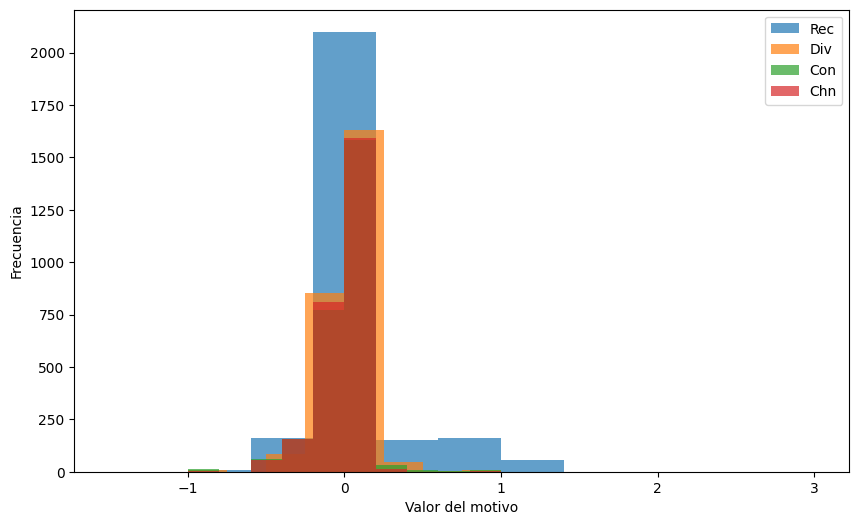

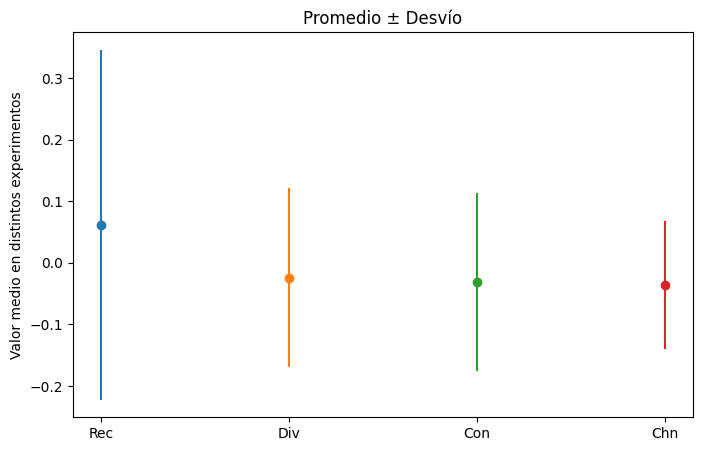

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Modify 'path' if it's necessary
data_size = 'medium'
path=fr'C:\\Users\\macevedo\\Desktop\\IB\\cache\\database\\synphys_r2.1_{data_size}.sqlite'

con = sqlite3.connect(path)
cur = con.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

# take only the table that has information about the connectivity
df9 = pd.read_sql_query("SELECT * from "+ str(table_list[9])[2:-3], con)

def compute_tau(count_motif, count_possible, sigma2, p):
    p_motif = safe_divide(count_motif,count_possible)

    return safe_divide((p_motif-p**2),sigma2)

def count_possible_reciprocal(df):
    
    measured_set = set(zip(df['pre_cell_id'], df['post_cell_id']))
    count_rec = 0
    checked = set()

    for (a, b) in measured_set:
        if (b, a) in measured_set and (b, a) not in checked and a != b:
            count_rec += 1
            checked.add((a, b))

    return count_rec

def count_triplets(df, motif_type='divergent'):
    
    measured_set = set(zip(df['pre_cell_id'], df['post_cell_id']))
    neurons = set(df['pre_cell_id']).union(set(df['post_cell_id']))
    possible_triplets = 0

    for a in neurons:
        for b in neurons:
            for c in neurons:
                if len({a, b, c}) < 3:
                    continue

                if motif_type == 'divergent' and (a, b) in measured_set and (a, c) in measured_set:
                    possible_triplets += 1

                elif motif_type == 'convergent' and (b, a) in measured_set and (c, a) in measured_set:
                    possible_triplets += 1

                elif motif_type == 'chain' and (a, b) in measured_set and (b, c) in measured_set:
                    possible_triplets += 1

    return possible_triplets


def compute_motifs(df):
    df_syn = df[df['has_synapse'] == 1]
    if len(df_syn) == 0:
        return (0, 0, 0, 0)

    num_synapses = len(df_syn)
    num_measured_pairs = len(df)
    p = num_synapses / num_measured_pairs
    sigma2 = p * (1 - p)

    # Cálculo de posibles tripletes y recíprocos en todo el dataset
    possible_rec = count_reciprocal(df)
    possible_triplets = {
        kind: count_triplets(df, kind)
        for kind in ['divergent', 'convergent', 'chain']
    }

    # Cálculo de motivos observados en conexiones sinápticas
    rec_count = count_reciprocal(df_syn)
    triplet_counts = {
        kind: count_triplets(df_syn, kind)
        for kind in ['divergent', 'convergent', 'chain']
    }

    print("Motivos observados:")
    print("Recíproco:", rec_count, "/", possible_rec)
    for kind in ['divergent', 'convergent', 'chain']:
        print(f"{kind.capitalize()}: {triplet_counts[kind]} / {possible_triplets[kind]}")

    # Calcular tau
    return tuple(
        compute_tau(
            count_motif=(rec_count if motif == 'reciprocal' else triplet_counts[motif]),
            count_possible=(possible_rec if motif == 'reciprocal' else possible_triplets[motif]),
            sigma2=sigma2,
            p=p
        )
        for motif in ['reciprocal', 'divergent', 'convergent', 'chain']
    )


### GRAPHS ###

# Eliminar filas con NaN en 'has_synapse'
df9 = df9.dropna(subset=['has_synapse'])

# Inicializar lista de resultados
motifs_list = []

# Calcular motivos por experimento (filtrando experimentos con al menos 3 pares)
for exp_id, df_exp in df9.groupby('experiment_id'):
    if len(df_exp) < 3:
        continue

    motivo_rec, motivo_div, motivo_con, motivo_chn = compute_motifs(df_exp)
    motifs_list.append({
        'experiment_id': exp_id,
        'motivo_rec': motivo_rec,
        'motivo_div': motivo_div,
        'motivo_con': motivo_con,
        'motivo_chn': motivo_chn
    })

# Crear DataFrame
df_motifs = pd.DataFrame(motifs_list)

# Histograma
plt.figure(figsize=(10, 6))
for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
    print(df_motifs[motif])
    plt.hist(
        df_motifs[motif],
        bins=10,
        alpha=0.7,
        label=motif.replace('motivo_', '').capitalize()
    )
plt.xlabel('Valor del motivo')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Promedios con barra de error
plt.figure(figsize=(8, 5))
for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
    mean = df_motifs[motif].mean()
    std = df_motifs[motif].std()
    plt.errorbar(motif.replace('motivo_', '').capitalize(), mean, yerr=std, fmt='o')

plt.ylabel('Valor medio en distintos experimentos')
plt.title('Promedio ± Desvío')
plt.show()

Comparaciones entre distintas funciones para unificar el codigo

In [18]:
def count_reciprocal(df):
    #del primer codigo, es la parte donde cuenta las cantidad de motivos en el set
    synaptic_connections = df[df['has_synapse'] == 1][['pre_cell_id', 'post_cell_id']].values
    connectivity = {(pre, post): 1 for pre, post in synaptic_connections}
    rec_count = 0

    for pre1, post1 in synaptic_connections:
        if (post1, pre1) in connectivity:
            rec_count += 1

    return rec_count


def count_possible_reciprocal(df):
    #del primer codigo, es la parte donde cuenta la cantidad de posibles motivos
    df = df[df['has_synapse'] == 1]
    measured_set = set(zip(df['pre_cell_id'], df['post_cell_id']))
    possible_rec = 0
    checked = set()

    for (a, b) in measured_set:
        if (b, a) in measured_set and (b, a) not in checked and a != b:
            possible_rec += 1
            checked.add((a, b))

    return possible_rec


# Comparación experimento por experimento
for i in df9['experiment_id'].unique():
    df_exp = df9[df9['experiment_id'] == i]

    if len(df_exp) < 3:
        continue

    rec1 = count_reciprocal(df_exp)
    rec2 = count_possible_reciprocal(df_exp)

    if rec1 != 2*rec2:  # porque rec1 cuenta dos veces cada recíproca
        print(f"Discrepancia en experimento {i}: rec1={rec1}, posible_reciprocals={rec2}")



Discrepancia en experimento 67: rec1=7, posible_reciprocals=2
Discrepancia en experimento 179: rec1=2, posible_reciprocals=0
Discrepancia en experimento 185: rec1=3, posible_reciprocals=1
Discrepancia en experimento 200: rec1=3, posible_reciprocals=1
Discrepancia en experimento 279: rec1=4, posible_reciprocals=1
Discrepancia en experimento 296: rec1=7, posible_reciprocals=2
Discrepancia en experimento 304: rec1=2, posible_reciprocals=0
Discrepancia en experimento 321: rec1=3, posible_reciprocals=1
Discrepancia en experimento 334: rec1=3, posible_reciprocals=1
Discrepancia en experimento 344: rec1=7, posible_reciprocals=2
Discrepancia en experimento 352: rec1=7, posible_reciprocals=3
Discrepancia en experimento 354: rec1=6, posible_reciprocals=1
Discrepancia en experimento 377: rec1=4, posible_reciprocals=1
Discrepancia en experimento 388: rec1=2, posible_reciprocals=0
Discrepancia en experimento 423: rec1=4, posible_reciprocals=1
Discrepancia en experimento 427: rec1=5, posible_recipro

Estaba contando mal, cuando contaba la cantidad de posibles motivos, si contaba A->B, luego no contaba B<-A, pero si lo hacía cuando contaba la cantidad de motivos existentes.

Si queremos quedarnos con la funcion que cuenta las repeticiones, debemos quedarnos con count_reciprocal.

Ahora veamos que sucede con los tripletes

In [ ]:
def count_possible_triplets(df):
    measured_set = set(zip(df['pre_cell_id'], df['post_cell_id']))
    neurons = set(df['pre_cell_id']).union(set(df['post_cell_id']))

    div_count = con_count = chn_count = 0
    for a in neurons:
        for b in neurons:
            for c in neurons:
                if len({a, b, c}) < 3:
                    continue

                if  (a, b) in measured_set and (a, c) in measured_set:
                    div_count += 1

                elif (b, a) in measured_set and (c, a) in measured_set:
                    con_count += 1

                elif  (a, b) in measured_set and (b, c) in measured_set:
                    chn_count += 1

    return div_count, con_count, chn_count

def count_triplets_codigos(df):

    synaptic_connections = df[['pre_cell_id', 'post_cell_id']].values
    div_count = con_count = chn_count = 0

    for pre1, post1 in synaptic_connections:
            # ACA SI YA CONTE EL PAR A-> <-B, también cuento luego B-> <-A
            for pre2, post2 in synaptic_connections:
                if pre1 == pre2 and post1 == post2:
                    continue
                if pre1 == pre2 and post1 != post2:
                    div_count += 1
                if post1 == post2 and pre1 != pre2:
                    con_count += 1
                if post1 == pre2 and pre1 != post2:
                    chn_count += 1

    return div_count, con_count, chn_count

In [17]:
def count_possible_triplets(df):
    measured_set = set(zip(df['pre_cell_id'], df['post_cell_id']))
    neurons = set(df['pre_cell_id']).union(set(df['post_cell_id']))

    div_count = con_count = chn_count = 0
    for a in neurons:
        for b in neurons:
            for c in neurons:
                if len({a, b, c}) < 3:
                    continue

                if (a, b) in measured_set and (a, c) in measured_set:
                    div_count += 1

                if (b, a) in measured_set and (c, a) in measured_set:
                    con_count += 1

                if (a, b) in measured_set and (b, c) in measured_set:
                    chn_count += 1

    return div_count, con_count, chn_count


def count_triplets_codigos(df):
    measured_set = df[['pre_cell_id', 'post_cell_id']].values
    div_count = con_count = chn_count = 0

    for pre1, post1 in measured_set:
        for pre2, post2 in measured_set:
            if pre1 == pre2 and post1 == post2:
                continue

            # Divergente: pre1 → post1 y pre1 → post2
            if pre1 == pre2 and post1 != post2 and len({pre1, post1, post2}) == 3:
                div_count += 1

            # Convergente: pre1 → post1 y pre2 → post1
            if post1 == post2 and pre1 != pre2 and len({pre1, post1, pre2}) == 3:
                con_count += 1

            # Cadena: pre1 → post1 (= pre2) → post2
            if post1 == pre2 and pre1 != post2 and len({pre1, post1, post2}) == 3:
                chn_count += 1

    return div_count, con_count, chn_count



# Comparación por experimento con contadores
coinciden = 0
difieren = 0

for i in df9['experiment_id'].unique():
    df_exp = df9[df9['experiment_id'] == i]

    if len(df_exp) < 3:
        continue

    triplets_possible = count_possible_triplets(df_exp)
    triplets_codigos = count_triplets_codigos(df_exp)


    print(f"Diferencias en experimento {i}")
    print(f"  count_possible_triplets: {triplets_possible}")
    print(f"  count_triplets_codigos:  {triplets_codigos}")




Diferencias en experimento 25
  count_possible_triplets: (210, 210, 210)
  count_triplets_codigos:  (210, 210, 210)
Diferencias en experimento 26
  count_possible_triplets: (60, 60, 60)
  count_triplets_codigos:  (60, 60, 60)
Diferencias en experimento 27
  count_possible_triplets: (336, 336, 336)
  count_triplets_codigos:  (336, 336, 336)
Diferencias en experimento 28
  count_possible_triplets: (336, 336, 336)
  count_triplets_codigos:  (336, 336, 336)
Diferencias en experimento 33
  count_possible_triplets: (6, 6, 6)
  count_triplets_codigos:  (6, 6, 6)
Diferencias en experimento 35
  count_possible_triplets: (24, 24, 24)
  count_triplets_codigos:  (24, 24, 24)
Diferencias en experimento 36
  count_possible_triplets: (336, 336, 336)
  count_triplets_codigos:  (336, 336, 336)
Diferencias en experimento 38
  count_possible_triplets: (336, 336, 336)
  count_triplets_codigos:  (336, 336, 336)
Diferencias en experimento 37
  count_possible_triplets: (336, 336, 336)
  count_triplets_codigo

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2634    1.000000
2635    1.000000
2636   -0.090909
2637    1.900000
2638   -0.090909
Name: motivo_rec, Length: 2639, dtype: float64
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2634   -0.500000
2635   -0.500000
2636   -0.090909
2637   -0.125000
2638   -0.090909
Name: motivo_div, Length: 2639, dtype: float64
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2634   -0.500000
2635   -0.500000
2636   -0.090909
2637   -0.350000
2638   -0.090909
Name: motivo_con, Length: 2639, dtype: float64
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2634   -0.500000
2635   -0.500000
2636   -0.090909
2637   -0.125000
2638   -0.090909
Name: motivo_chn, Length: 2639, dtype: float64


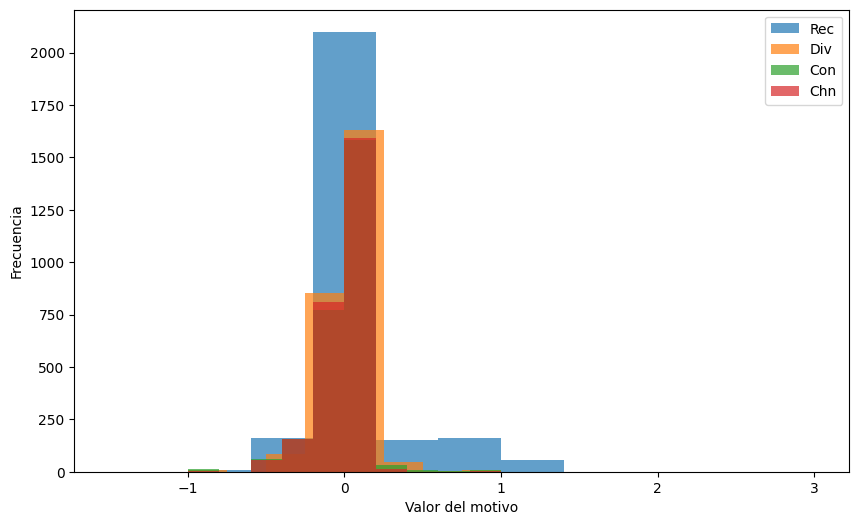

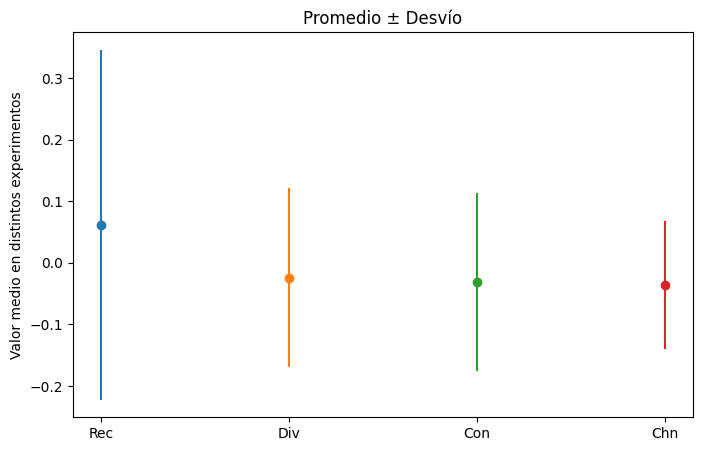

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#CARGO TABLA
data_size = 'medium'
path=fr'C:\\Users\\macevedo\\Desktop\\IB\\cache\\database\\synphys_r2.1_{data_size}.sqlite'
con = sqlite3.connect(path)
cur = con.cursor()

table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
df9 = pd.read_sql_query("SELECT * from "+ str(table_list[9])[2:-3], con)
# Eliminar filas con NaN en 'has_synapse'
df9 = df9.dropna(subset=['has_synapse'])



## CUENTO PATRONES ##
def count_reciprocal(df):
    #del primer codigo, es la parte donde cuenta las cantidad de motivos en el set
    synaptic_connections = df[['pre_cell_id', 'post_cell_id']].values
    connectivity = {(pre, post): 1 for pre, post in synaptic_connections}
    rec_count = 0

    for pre1, post1 in synaptic_connections:
        if (post1, pre1) in connectivity:
            rec_count += 1

    return rec_count

def count_triplets(df):
    measured_set = df[['pre_cell_id', 'post_cell_id']].values
    div_count = con_count = chn_count = 0

    for pre1, post1 in measured_set:
        for pre2, post2 in measured_set:
            if pre1 == pre2 and post1 == post2:
                continue

            # Divergente: pre1 → post1 y pre1 → post2
            if pre1 == pre2 and post1 != post2 and len({pre1, post1, post2}) == 3:
                div_count += 1

            # Convergente: pre1 → post1 y pre2 → post1
            if post1 == post2 and pre1 != pre2 and len({pre1, post1, pre2}) == 3:
                con_count += 1

            # Cadena: pre1 → post1 (= pre2) → post2
            if post1 == pre2 and pre1 != post2 and len({pre1, post1, post2}) == 3:
                chn_count += 1

    return div_count, con_count, chn_count

### CALCULO MOTIFS ###

def compute_tau(count_motif, count_possible, sigma2, p):
    p_motif = safe_divide(count_motif,count_possible)

    return safe_divide((p_motif-p**2),sigma2)

def compute_motifs(df):

    possible_rec = count_reciprocal(df)
    possible_div, possible_con, possible_chn = count_triplets(df)

    df_syn = df[df['has_synapse'] == 1]

    rec_count = count_reciprocal(df_syn)
    div_count, con_count, chn_count = count_triplets(df_syn)

    if len(df_syn) == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    
    p = len(df_syn) / len(df)
    sigma2 = p * (1 - p)

    tau_rec = compute_tau(rec_count, possible_rec, sigma2, p)
    tau_div = compute_tau(div_count, possible_div, sigma2, p)
    tau_con = compute_tau(con_count, possible_con, sigma2, p)
    tau_chn = compute_tau(chn_count, possible_chn, sigma2, p)

    return tau_rec, tau_div, tau_con, tau_chn


### GRAFICOS ###

# Inicializar lista de resultados
motifs_list = []

# Calcular motivos por experimento (filtrando experimentos con al menos 3 pares)
for exp_id, df_exp in df9.groupby('experiment_id'):
    if len(df_exp) < 3:
        continue

    motivo_rec, motivo_div, motivo_con, motivo_chn = compute_motifs(df_exp)
    motifs_list.append({
        'experiment_id': exp_id,
        'motivo_rec': motivo_rec,
        'motivo_div': motivo_div,
        'motivo_con': motivo_con,
        'motivo_chn': motivo_chn
    })

# Crear DataFrame
df_motifs = pd.DataFrame(motifs_list)

# Histograma
plt.figure(figsize=(10, 6))
for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
    print(df_motifs[motif])
    plt.hist(
        df_motifs[motif],
        bins=10,
        alpha=0.7,
        label=motif.replace('motivo_', '').capitalize()
    )
plt.xlabel('Valor del motivo')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


plt.figure(figsize=(8, 5))
for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
    mean = df_motifs[motif].mean()
    std = df_motifs[motif].std()
    plt.errorbar(motif.replace('motivo_', '').capitalize(), mean, yerr=std, fmt='o')

plt.ylabel('Valor medio en distintos experimentos')
plt.title('Promedio ± Desvío')
plt.show()



In [30]:
def calcular_probabilidades_primer_orden(df): 
    
    p_ex = df[df['pre_cell_class'] == 'ex']['has_synapse'].mean()
    p_in = df[df['pre_cell_class'] == 'in']['has_synapse'].mean()

    return p_ex, p_in

def calcular_probabilidades_segundo_orden(df):

    p_ex_ex = df[(df['pre_cell_class'] == 'ex') & (df['post_cell_class'] == 'ex')]['has_synapse'].mean()
    p_ex_in = df[(df['post_cell_class'] == 'ex') & (df['pre_cell_class'] == 'in')]['has_synapse'].mean()
    p_in_ex = df[(df['post_cell_class'] == 'in') & (df['pre_cell_class'] == 'ex')]['has_synapse'].mean()
    p_in_in = df[(df['pre_cell_class'] == 'in') & (df['post_cell_class'] == 'in')]['has_synapse'].mean()

    return p_ex_ex, p_ex_in, p_in_ex, p_in_in


In [ ]:
## CUENTO PATRONES ##
def safe_divide(n, d):
    return n / d if d != 0 else np.nan

from itertools import combinations

def count_reciprocal_simple(df):
    # mapea si existe sinapsis en cada dirección
    connectivity = set(map(tuple, df[['pre_cell_id','post_cell_id']].values))
    rec_EE = rec_EI = rec_II = 0

    # iteramos combinaciones no ordenadas de pares de neuronas
    neurons = df['pre_cell_id'].unique()
    for a, b in combinations(neurons, 2):
        # ¿existe A→B y B→A?
        if (a,b) in connectivity and (b,a) in connectivity:
            class_a = df.loc[df.pre_cell_id==a, 'pre_cell_class'].iat[0]
            class_b = df.loc[df.pre_cell_id==b, 'pre_cell_class'].iat[0]
            if class_a=='ex' and class_b=='ex':
                rec_EE += 1
            elif class_a=='in' and class_b=='in':
                rec_II += 1
            else:
                rec_EI += 1
    return rec_EE, rec_EI, rec_II



def count_divergent(df):

    div_E = div_I = 0

    # Para cada presináptico, mira sus posts y elige pares de posts
    for pre, subdf in df.groupby('pre_cell_id'):
        posts = subdf['post_cell_id'].unique()
        for post1, post2 in combinations(posts, 2):
            # asegúrate de que sean tres neuronas distintas
            if post1 == post2 or post1 == pre or post2 == pre:
                continue
            clase = subdf['pre_cell_class'].iloc[0]
            if clase == 'ex':
                div_E += 1
            else:
                div_I += 1

    return div_E, div_I


def count_convergent(df):
    df = df[df['has_synapse'].notnull()]
    con_EE = con_II = con_EI = 0

    # Para cada postsináptico, mira sus pres y elige pares de pres
    for post, subdf in df.groupby('post_cell_id'):
        pres = subdf['pre_cell_id'].unique()
        for pre1, pre2 in combinations(pres, 2):
            if pre1 == post or pre2 == post:
                continue
            clase1 = subdf[subdf['pre_cell_id']==pre1]['pre_cell_class'].iloc[0]
            clase2 = subdf[subdf['pre_cell_id']==pre2]['pre_cell_class'].iloc[0]
            if clase1=='ex' and clase2=='ex':
                con_EE += 1
            elif clase1=='in' and clase2=='in':
                con_II += 1
            else:
                con_EI += 1

    return con_EE, con_EI, con_II


def count_chain(df):
    df = df[df['has_synapse'].notnull()]
    chn_EE = chn_EI = chn_IE = chn_II = 0

    # Primero agrupa las conexiones por su nodo intermedio gamma
    # gamma es aquel que aparece como post en la primera conexión y pre en la segunda
    # de modo que recorro gamma, miro todos pre→gamma y gamma→post
    for gamma in set(df['pre_cell_id']).intersection(df['post_cell_id']):
        ins  = df[df['post_cell_id']==gamma]  # conexiones pre→gamma
        outs = df[df['pre_cell_id']==gamma]   # conexiones gamma→post
        pres = ins['pre_cell_id'].unique()
        posts = outs['post_cell_id'].unique()
        # combino cada pre con cada post
        for pre, post in ((p, q) for p in pres for q in posts):
            if pre in (gamma, post) or post in (gamma, pre):
                continue
            clase_pre  = ins[ins['pre_cell_id']==pre]['pre_cell_class'].iloc[0]
            clase_mid  = ins[ins['post_cell_id']==gamma]['pre_cell_class'].iloc[0]
            # ojo: pre→gamma→post  ⇒ β=pre, γ=gamma
            if clase_pre=='ex' and clase_mid=='ex':
                chn_EE += 1
            elif clase_pre=='ex' and clase_mid=='in':
                chn_EI += 1
            elif clase_pre=='in' and clase_mid=='ex':
                chn_IE += 1
            elif clase_pre=='in' and clase_mid=='in':
                chn_II += 1

    return chn_EE, chn_EI, chn_IE, chn_II

                

### CALCULO MOTIFS ###

def compute_tau(count_motif, count_possible, p):

    sigma2 = p*(1-p)
    p_motif = safe_divide(count_motif,count_possible)

    return safe_divide((p_motif-p),np.sqrt(sigma2))

def compute_motifs(df):

    
    rec_pos_EE, rec_pos_EI, rec_pos_II = count_reciprocal(df)
    div_pos_E, div_pos_I = count_divergent(df)
    con_pos_EE, con_pos_EI, con_pos_II = count_convergent(df)
    chn_pos_EE, chn_pos_EI,  chn_pos_IE, chn_pos_II = count_chain(df)



    df_syn = df[df['has_synapse'] == 1]

    rec_count_EE, rec_count_EI, rec_count_II = count_reciprocal(df_syn)
    div_count_E, div_count_I = count_divergent(df_syn)
    con_count_EE, con_count_EI,con_count_II = count_convergent(df_syn)
    chn_count_EE, chn_count_EI,chn_count_IE, chn_count_II = count_chain(df_syn)

    if len(df_syn) == 0:
        return (0,) * 11 
    
    p_ex, p_in = calcular_probabilidades_primer_orden(df)
    p_ex_ex, p_ex_in, p_in_ex, p_in_in = calcular_probabilidades_segundo_orden(df)
    

    tau_rec_EE = compute_tau(rec_count_EE, rec_pos_EE, p_ex_ex*p_ex_ex)
    tau_rec_EI = compute_tau(rec_count_EI, rec_pos_EI, p_ex_in*p_in_ex)
    tau_rec_II = compute_tau(rec_count_II, rec_pos_II, p_in_in*p_in_in)

    tau_div_E = compute_tau(div_count_E, div_pos_E, p_ex**2)
    tau_div_I = compute_tau(div_count_I, div_pos_I, p_in**2)

    tau_con_EE = compute_tau(con_count_EE, con_pos_EE, p_ex*p_ex)
    tau_con_EI = compute_tau(con_count_EI, con_pos_EI, p_in*p_ex)
    tau_con_II = compute_tau(con_count_II, con_pos_II, p_in*p_in)

    tau_chn_EE = compute_tau(chn_count_EE, chn_pos_EE, p_ex*p_ex_ex)
    tau_chn_EI = compute_tau(chn_count_EI, chn_pos_EI, p_in*p_ex_in)
    tau_chn_II = compute_tau(chn_count_II, chn_pos_II, p_in*p_in_in) 

    return tau_rec_EE, tau_rec_EI, tau_rec_II, tau_div_E, tau_div_I, tau_con_EE, tau_con_EI, tau_con_II, tau_chn_EE, tau_chn_EI, tau_chn_II

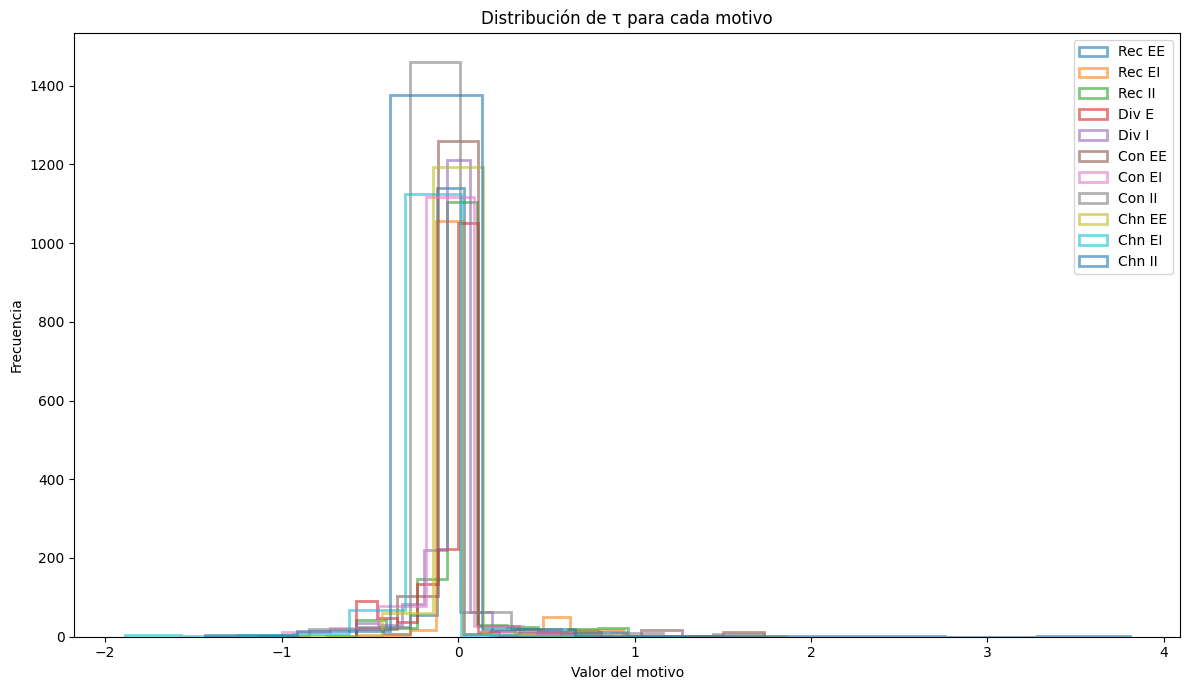

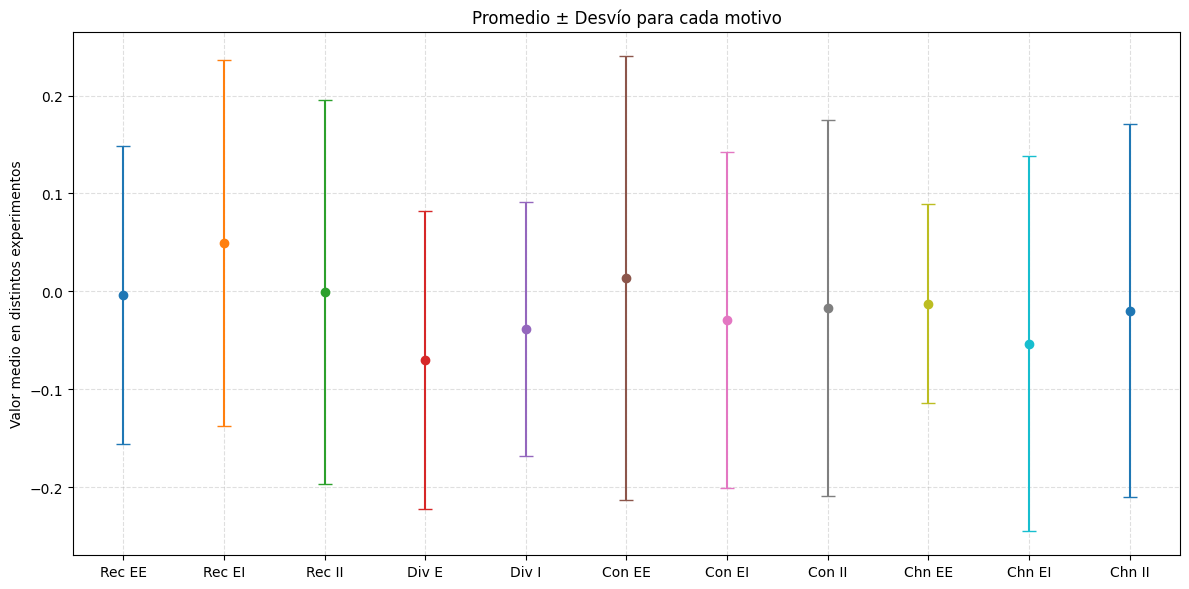

In [ ]:
con = sqlite3.connect(path)
cur = con.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

# take only the table that has information about the connectivity
df7 = pd.read_sql_query("SELECT * from "+ str(table_list[7])[2:-3], con)
df9 = pd.read_sql_query("SELECT * from "+ str(table_list[9])[2:-3], con)


# Unimos los dataframes con las columnas que te interesan
df_merged = pd.merge(df9[['id', 'experiment_id', 'has_synapse', 'pre_cell_id', 'post_cell_id']],
                     df7[['id', 'cell_class']],
                     left_on='pre_cell_id', right_on='id')
df_merged.rename(columns={'cell_class': 'pre_cell_class'}, inplace=True)

# Seleccionamos y ordenamos las columnas deseadas
df_result = df_merged[['experiment_id','pre_cell_id', 'post_cell_id', 'has_synapse', 'pre_cell_class']]
df_result = df_result[df_result['pre_cell_class']!= 'mixed']

# Merge adicional entre post_cell_id y id en df7
df_result = pd.merge(df_result,
                     df7[['id', 'cell_class']],
                     left_on='post_cell_id', right_on='id',
                     suffixes=('_pre', '_post'))

# Filtramos los resultados para que los 'pre_cell_class' no sean 'mixed'
df_result = df_result[df_result['pre_cell_class'] != 'mixed']

# Si quieres cambiar el nombre de la columna 'cell_class_post' por ejemplo, puedes hacerlo de la siguiente manera:
df_result.rename(columns={'cell_class': 'post_cell_class'}, inplace=True)


df_result = df_result[['experiment_id','pre_cell_id', 'post_cell_id', 'has_synapse', 'pre_cell_class', 'post_cell_class']]
df_clean = df_result.dropna(subset=['pre_cell_class', 'post_cell_class', 'has_synapse'])

# Inicializar lista de resultados
motifs_list = []

# Calcular motivos por experimento (filtrando experimentos con al menos 3 pares)
for exp_id, df_exp in df_clean.groupby('experiment_id'):
    if len(df_exp) < 3:
        continue

    result = compute_motifs(df_exp)
    motifs_list.append({
        'experiment_id': exp_id,
        'tau_rec_EE': result[0],
        'tau_rec_EI': result[1],
        'tau_rec_II': result[2],
        'tau_div_E': result[3],
        'tau_div_I': result[4],
        'tau_con_EE': result[5],
        'tau_con_EI': result[6],
        'tau_con_II': result[7],
        'tau_chn_EE': result[8],
        'tau_chn_EI': result[9],
        'tau_chn_II': result[10],
    })

# Crear DataFrame
df_motifs = pd.DataFrame(motifs_list)


import matplotlib.pyplot as plt

motif_labels = {
    'tau_rec_EE': 'Rec EE', 'tau_rec_EI': 'Rec EI', 'tau_rec_II': 'Rec II',
    'tau_div_E': 'Div E', 'tau_div_I': 'Div I',
    'tau_con_EE': 'Con EE', 'tau_con_EI': 'Con EI', 'tau_con_II': 'Con II',
    'tau_chn_EE': 'Chn EE', 'tau_chn_EI': 'Chn EI', 'tau_chn_II': 'Chn II'
}





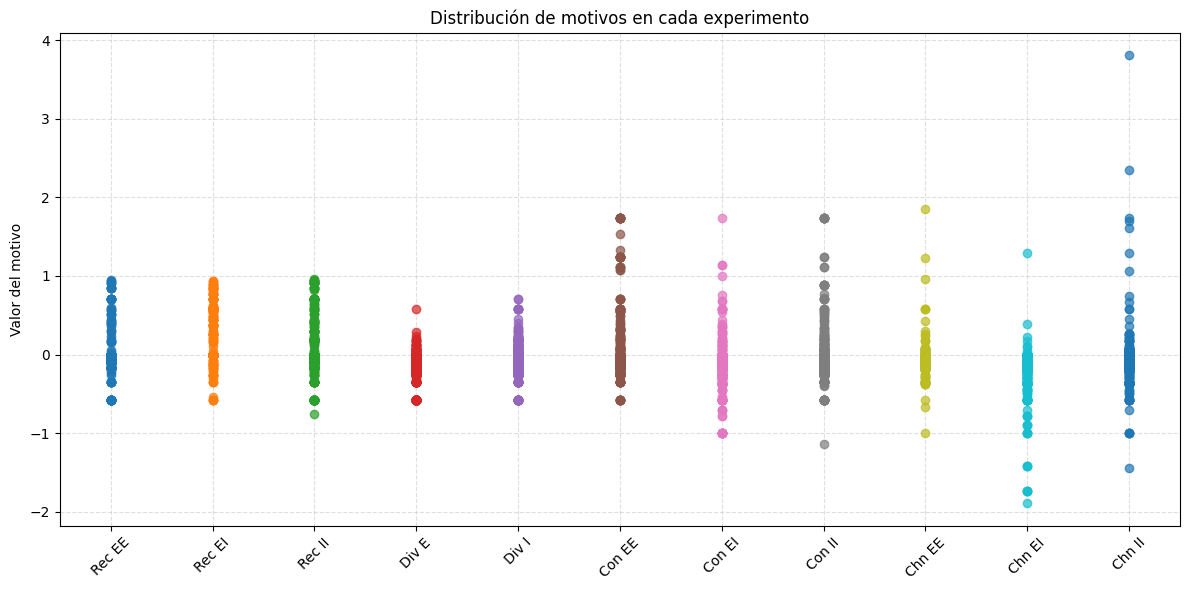

In [69]:
plt.figure(figsize=(12, 6))

for i, motif in enumerate(df_motifs.columns[1:]):
    y = df_motifs[motif]
    x = [motif_labels[motif]] * len(y)  # repetir el nombre del motivo para cada punto
    plt.plot(x, y, 'o', alpha=0.7)      # graficar los puntos


plt.ylabel('Valor del motivo')
plt.title('Distribución de motivos en cada experimento')
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


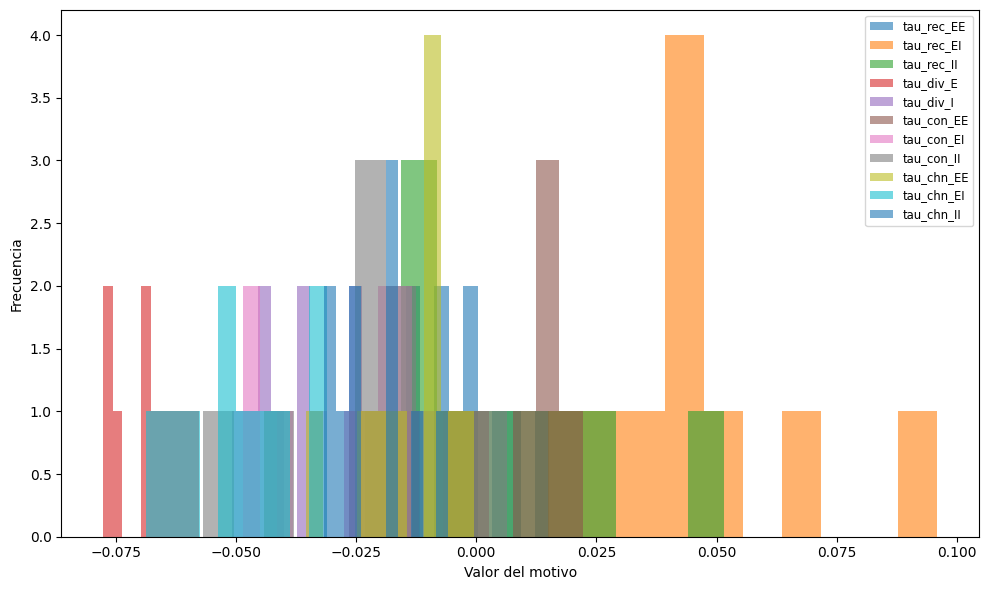

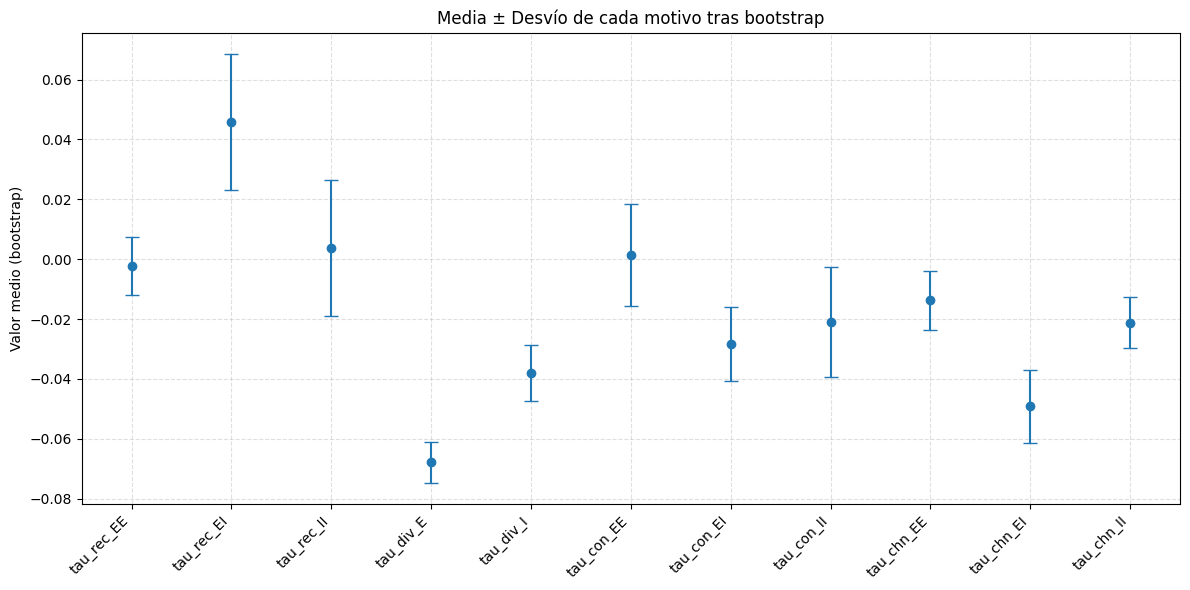

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lista de etiquetas de motivos según la función compute_motifs
motif_labels = [
    'tau_rec_EE', 'tau_rec_EI', 'tau_rec_II',
    'tau_div_E', 'tau_div_I',
    'tau_con_EE', 'tau_con_EI', 'tau_con_II',
    'tau_chn_EE', 'tau_chn_EI', 'tau_chn_II'
]

def bootstrap_motifs_sep(df_clean, compute_motifs, nboot=10, sample_frac=0.1, seed=42):
    """
    Parámetros:
    ----------
    df_clean : pd.DataFrame
        DataFrame con columna 'experiment_id' y los datos de conectividad limpios.
    compute_motifs : función
        Función que devuelve una tupla de 11 valores (tau_rec_EE, ..., tau_chn_II).
    nboot : int
        Número de iteraciones de bootstrap.
    sample_frac : float
        Fracción de experimentos a muestrear (por defecto 0.1 = 10%).
    seed : int
        Semilla para reproducibilidad.

    Devuelve:
    -------
    pd.DataFrame
        DataFrame con nboot filas y columnas ['boot'] + motif_labels.
    """
    np.random.seed(seed)
    exps = df_clean['experiment_id'].unique()

    # Preparar contenedor de resultados
    data = {'boot': []}
    for label in motif_labels:
        data[label] = []

    for iboot in range(nboot):
        # Muestreo sin reemplazo de sample_frac de experimentos
        n_sample = max(1, int(len(exps) * sample_frac))
        sampled_exps = np.random.choice(exps, size=n_sample, replace=False)

        # Guardar valores de cada motivo en esta iteración
        metrics = {label: [] for label in motif_labels}

        for exp_id in sampled_exps:
            df_exp = df_clean[df_clean['experiment_id'] == exp_id]
            if len(df_exp) < 3:
                continue
            result = compute_motifs(df_exp)
            for label, val in zip(motif_labels, result):
                metrics[label].append(val)

        # Añadir resultados promediados
        data['boot'].append(iboot)
        for label in motif_labels:
            data[label].append(np.nanmean(metrics[label]))

    return pd.DataFrame(data)


# ---------------- EJEMPLO DE USO ----------------
# df_clean ya generado y compute_motifs definido previamente

# Ejecutamos bootstrap
nboot = 10
df_boot = bootstrap_motifs_sep(df_clean, compute_motifs, nboot=nboot, sample_frac=0.1, seed=123)

# 1) Histogramas de cada motivo
plt.figure(figsize=(10, 6))
for label in motif_labels:
    plt.hist(df_boot[label], bins=10, alpha=0.6, label=label)
plt.xlabel('Valor del motivo')
plt.ylabel('Frecuencia')
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()

# 2) Media ± Desvío para cada motivo
means = df_boot[motif_labels].mean()
stds  = df_boot[motif_labels].std()

plt.figure(figsize=(12, 6))
x = np.arange(len(motif_labels))
plt.errorbar(x, means, yerr=stds, fmt='o', capsize=5)
plt.xticks(x, motif_labels, rotation=45, ha='right')
plt.ylabel('Valor medio (bootstrap)')
plt.title('Media ± Desvío de cada motivo tras bootstrap')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [12]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from collections import Counter

#CARGO TABLA
data_size = 'medium'
path=fr'C:\\Users\\macevedo\\Desktop\\IB\\cache\\database\\synphys_r2.1_{data_size}.sqlite'
con = sqlite3.connect(path)
cur = con.cursor()

table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
df9 = pd.read_sql_query("SELECT * from "+ str(table_list[9])[2:-3], con)
# Eliminar filas con NaN en 'has_synapse'
df9 = df9.dropna(subset=['has_synapse'])



## CUENTO PATRONES ##

def count_reciprocal(df):
    # Mapea si existe sinapsis en cada dirección
    connectivity = set(map(tuple, df[['pre_cell_id','post_cell_id']].values))
    rec = 0

    # Itera sobre combinaciones no ordenadas de pares de neuronas (toma combinaciones, entonces cuenta los pares de conexiones una sola vez)
    neurons = df['pre_cell_id'].unique()
    for a, b in combinations(neurons, 2):
        # ¿Existe A→B y B→A?
        if (a,b) in connectivity and (b,a) in connectivity:
            rec += 1

    return rec

def count_divergent(df):
    div = 0
    # Para cada presináptico, mira sus posts y elige pares de posts
    for pre, subdf in df.groupby('pre_cell_id'):
        posts = subdf['post_cell_id'].unique()
        for post1, post2 in combinations(posts, 2):
            # Asegura que sean tres neuronas distintas
            if post1 == post2 or post1 == pre or post2 == pre:
                continue
            div += 1

    return div

def count_convergent(df):
    con = 0

    # Para cada postsináptico, mira sus pres y elige pares de pres
    for post, subdf in df.groupby('post_cell_id'):
        pres = subdf['pre_cell_id'].unique()
        for pre1, pre2 in combinations(pres, 2):
            if pre1 == post or pre2 == post:
                continue
            con += 1

    return con

def count_chain(df):

    chn = 0

    # Gamma es nodo intermedio: aparece como post en una conexión y pre en otra
    for gamma in set(df['pre_cell_id']).intersection(df['post_cell_id']):
        ins  = df[df['post_cell_id']==gamma]  # conexiones pre→gamma
        outs = df[df['pre_cell_id']==gamma]   # conexiones gamma→post
        pres = ins['pre_cell_id'].unique()
        posts = outs['post_cell_id'].unique()
        # Combina cada pre con cada post
        for pre, post in ((p, q) for p in pres for q in posts):
            if pre in (gamma, post) or post in (gamma, pre):
                continue
            chn += 1

    return chn

### CALCULO MOTIFS ###
# Devuelve np.nan si el denominador es cero
def safe_divide(n, d):
    return n / d if d != 0 else np.nan

def compute_tau(count_motif, count_possible, sigma2, p):
    p_motif = safe_divide(count_motif,count_possible)

    return safe_divide((p_motif-p**2),sigma2)

def compute_motifs(df):
    #para calcular los posibles motivos tomamos el data frame donde la columna 'has_synapse' toma valores 0 o 1
    # es decir, se realizo la medición y como resultado se determino que hay ('has_synapse' = 1) o no hay ('has_synapse' =1) sinápsis
    possible_rec = count_reciprocal(df)
    possible_div = count_divergent(df)
    possible_con = count_convergent(df)
    possible_chn = count_chain(df)

    # Ahora, para calcular la cantidad de motivos que efectivamente hay en los datos, calculo la cantidad de motivos presentes entre el subconjunto de mediciones en las que se detecto una sinapsis ('has_synapsis'=1)
    df_syn = df[df['has_synapse'] == 1]

    rec_count = count_reciprocal(df_syn)
    div_count = count_divergent(df_syn)
    con_count = count_convergent(df_syn)
    chn_count = count_chain(df_syn)


    if len(df_syn) == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    
    p = len(df_syn) / len(df)
    
    sigma2 = p * (1 - p)

    tau_rec = compute_tau(rec_count, possible_rec, sigma2, p)
    tau_div = compute_tau(div_count, possible_div, sigma2, p)
    tau_con = compute_tau(con_count, possible_con, sigma2, p)
    tau_chn = compute_tau(chn_count, possible_chn, sigma2, p)
    print(p, tau_rec)

    return tau_rec, tau_div, tau_con, tau_chn



21
25
26
27
28
33
35
36
37
38
39
40
41
44
46
47
49
52
53
54
57
59
61
63
64
65
66
67
73
78
79
80
81
82
85
86
87
88
89
96
97
98
99
103
104
106
107
108
110
111
113
116
117
119
122
134
135
137
143
144
145
150
152
153
155
156
160
162
163
164
165
168
169
170
171
174
177
179
182
184
185
186
188
189
191
194
195
196
197
198
199
200
201
202
205
207
210
213
215
218
219
221
223
224
225
226
227
228
230
233
235
236
241
243
244
245
246
247
248
249
250
253
254
255
256
257
258
259
260
261
263
264
267
269
270
271
273
274
277
278
279
280
283
284
287
288
289
290
291
292
294
295
296
297
298
299
300
301
303
304
305
306
307
308
310
311
312
314
315
316
317
320
321
322
323
325
326
329
330
331
332
333
334
335
336
337
338
339
340
341
344
349
352
353
354
355
356
357
358
359
360
361
362
363
364
368
369
370
372
373
374
377
379
380
381
382
383
384
385
387
388
389
392
394
395
396
397
398
399
400
404
405
406
408
409
410
411
412
413
414
415
416
417
418
422
423
424
427
430
431
433
434
436
439
440
444
445
446
447
448
449

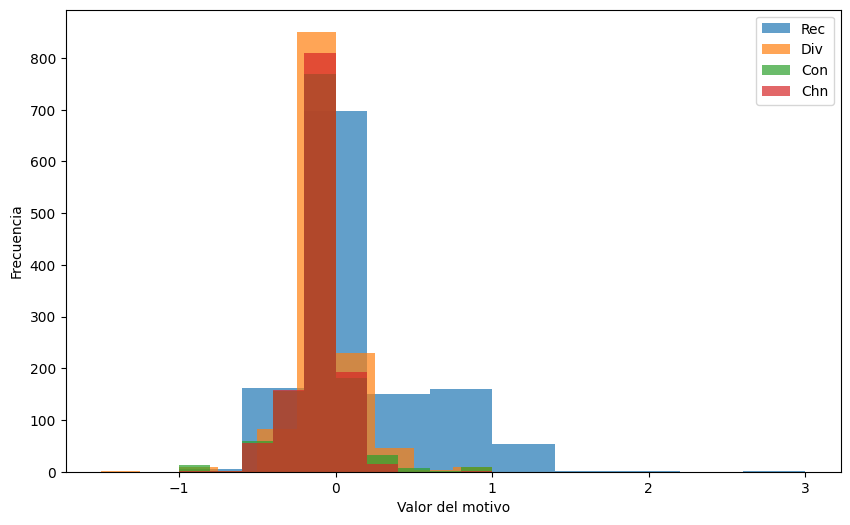

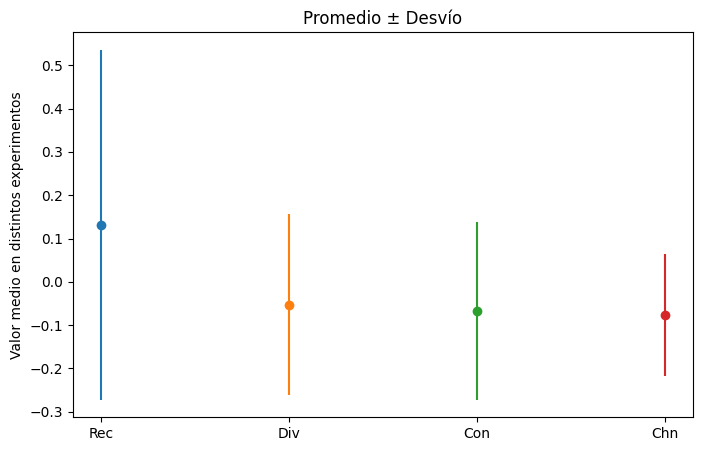

In [6]:
### GRAFICOS ###

# Inicializar lista de resultados
motifs_list = []

# Calcular motivos por experimento (filtrando experimentos con al menos 3 pares)
for exp_id, df_exp in df9.groupby('experiment_id'):
    print(exp_id)
    if len(df_exp) < 3:
        continue

    motivo_rec, motivo_div, motivo_con, motivo_chn = compute_motifs(df_exp)
    motifs_list.append({
        'experiment_id': exp_id,
        'motivo_rec': motivo_rec,
        'motivo_div': motivo_div,
        'motivo_con': motivo_con,
        'motivo_chn': motivo_chn
    })

# Crear DataFrame
df_motifs = pd.DataFrame(motifs_list)
print(df_motifs)
# Histograma
plt.figure(figsize=(10, 6))
for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
    
    plt.hist(
        df_motifs[motif],
        bins=10,
        alpha=0.7,
        label=motif.replace('motivo_', '').capitalize()
    )
plt.xlabel('Valor del motivo')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


plt.figure(figsize=(8, 5))
for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
    mean = df_motifs[motif].mean()
    std = df_motifs[motif].std()
    plt.errorbar(motif.replace('motivo_', '').capitalize(), mean, yerr=std, fmt='o')

plt.ylabel('Valor medio en distintos experimentos')
plt.title('Promedio ± Desvío')
plt.show()

nan
nan
0.017857142857142856 -0.01818181818181818
-0.01818181818181818
0.017857142857142856 -0.01818181818181818
-0.01818181818181818
nan
0.09523809523809523 -0.10526315789473684
-0.10526315789473684
0.3333333333333333 -0.49999999999999994
-0.49999999999999994
nan
0.05357142857142857 -0.056603773584905655
-0.056603773584905655
0.125 0.5102040816326531
0.5102040816326531
nan
nan
0.19642857142857142 0.4343434343434343
0.4343434343434343
nan
0.6 0.5833333333333334
0.5833333333333334
0.16666666666666666 -0.19999999999999998
-0.19999999999999998
nan
nan
nan
nan
0.23333333333333334 0.4409937888198758
0.4409937888198758
nan
nan
nan
0.017857142857142856 -0.01818181818181818
-0.01818181818181818
nan
nan
0.047619047619047616 -0.05
-0.05
nan
0.05 -0.05263157894736843
-0.05263157894736843
nan
0.017857142857142856 -0.01818181818181818
-0.01818181818181818
0.25 0.20000000000000004
0.20000000000000004
nan
0.3333333333333333 -0.49999999999999994
-0.49999999999999994
nan
0.047619047619047616 1.00000000

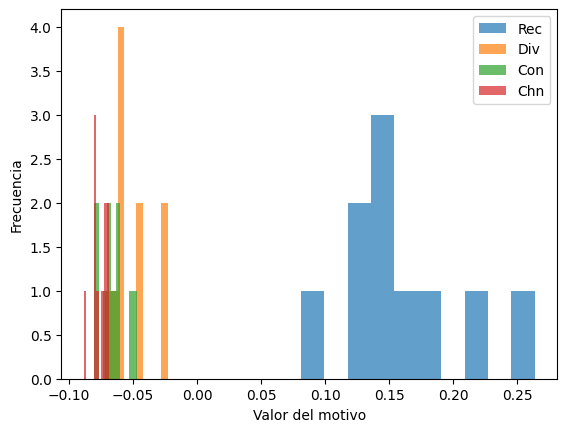

Text(0, 0.5, 'Valor medio en distintos experimentos')

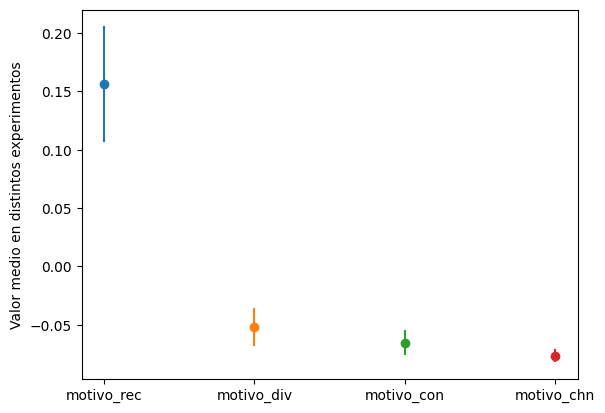

In [15]:
motifs_data = {
    'experiment_id': [],
    'motivo_rec': [],
    'motivo_div': [],
    'motivo_con': [],
    'motivo_chn': []
}

nboot=10
df9 = df9.dropna(subset=['has_synapse'])
iexp=df9['experiment_id'].unique()


for iboot in range(nboot):
    iexp_i=iexp[np.random.choice(len(iexp), size=int(len(iexp)*0.1), replace=False)]
    
    av_rec=[]
    av_div=[]
    av_con=[]
    av_chn=[]
    for i in iexp_i:
 
        if len(df9[df9['experiment_id'] == i]) < 3:
            continue
    
        df_exp = df9[df9['experiment_id'] == i]
        
        motivo_rec, motivo_div, motivo_con, motivo_chn = compute_motifs(df_exp)
       
        av_rec.append(motivo_rec)
        av_div.append(motivo_div)
        av_con.append(motivo_con)
        av_chn.append(motivo_chn)
    
    av_rec=np.nanmean(np.array(av_rec))
    av_div=np.nanmean(np.array(av_div))
    av_con=np.nanmean(np.array(av_con))
    av_chn=np.nanmean(np.array(av_chn))
    
    motifs_data['experiment_id'].append(iboot) 
    motifs_data['motivo_rec'].append(av_rec)
    motifs_data['motivo_div'].append(av_div)
    motifs_data['motivo_con'].append(av_con)
    motifs_data['motivo_chn'].append(av_chn)

df_motifs = pd.DataFrame(motifs_data)

for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
     plt.hist(
         df_motifs[motif].dropna(),   
         alpha=0.7, 
         bins = 10,
         label=motif.replace('motivo_', '').capitalize()
     )

plt.xlabel('Valor del motivo')
plt.ylabel('Frecuencia')


plt.legend()

plt.show()

for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
     plt.errorbar(x=motif, y=np.mean(df_motifs[motif]), yerr=np.std(df_motifs[motif]), fmt='o', label=motif.replace('motivo_', '').capitalize())

plt.ylabel('Valor medio en distintos experimentos')



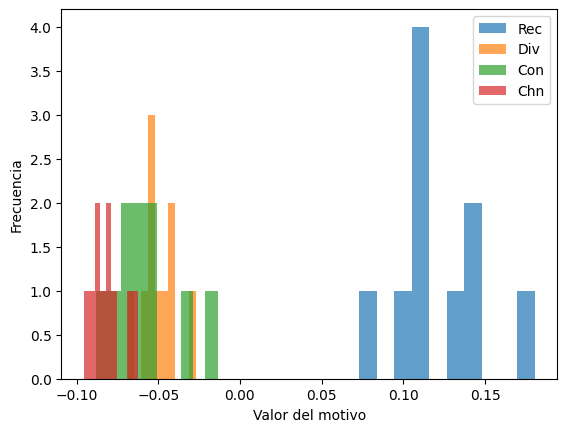

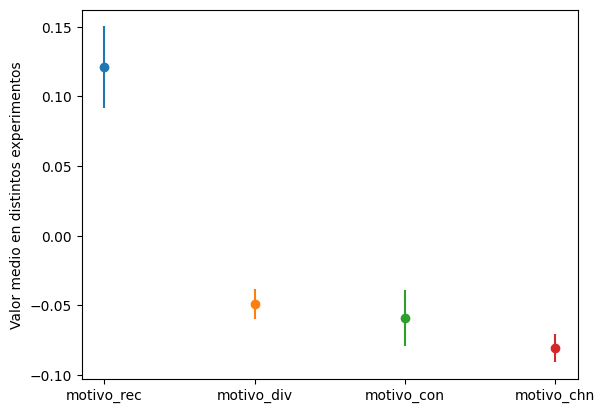

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from collections import Counter

#CARGO TABLA
data_size = 'medium'
path=fr'C:\\Users\\macevedo\\Desktop\\IB\\cache\\database\\synphys_r2.1_{data_size}.sqlite'
con = sqlite3.connect(path)
cur = con.cursor()

table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
df9 = pd.read_sql_query("SELECT * from "+ str(table_list[9])[2:-3], con)
# Eliminar filas con NaN en 'has_synapse'
df9 = df9.dropna(subset=['has_synapse'])


## CUENTO PATRONES ##

def count_reciprocal(df):
    # Mapea si existe sinapsis en cada dirección
    connectivity = set(map(tuple, df[['pre_cell_id','post_cell_id']].values))
    rec = 0

    # Itera sobre combinaciones no ordenadas de pares de neuronas (toma combinaciones, entonces cuenta los pares de conexiones una sola vez)
    neurons = df['pre_cell_id'].unique()
    for a, b in combinations(neurons, 2):
        # ¿Existe A→B y B→A?
        if (a,b) in connectivity and (b,a) in connectivity:
            rec += 1

    return rec

def count_divergent(df):
    div = 0
    # Para cada presináptico, mira sus posts y elige pares de posts
    for pre, subdf in df.groupby('pre_cell_id'):
        posts = subdf['post_cell_id'].unique()
        for post1, post2 in combinations(posts, 2):
            # Asegura que sean tres neuronas distintas
            if post1 == post2 or post1 == pre or post2 == pre:
                continue
            div += 1

    return div

def count_convergent(df):
    con = 0

    # Para cada postsináptico, mira sus pres y elige pares de pres
    for post, subdf in df.groupby('post_cell_id'):
        pres = subdf['pre_cell_id'].unique()
        for pre1, pre2 in combinations(pres, 2):
            if pre1 == post or pre2 == post:
                continue
            con += 1

    return con

def count_chain(df):

    chn = 0

    # Gamma es nodo intermedio: aparece como post en una conexión y pre en otra
    for gamma in set(df['pre_cell_id']).intersection(df['post_cell_id']):
        ins  = df[df['post_cell_id']==gamma]  # conexiones pre→gamma
        outs = df[df['pre_cell_id']==gamma]   # conexiones gamma→post
        pres = ins['pre_cell_id'].unique()
        posts = outs['post_cell_id'].unique()
        # Combina cada pre con cada post
        for pre, post in ((p, q) for p in pres for q in posts):
            if pre in (gamma, post) or post in (gamma, pre):
                continue
            chn += 1

    return chn

### CALCULO MOTIFS ###
# Devuelve np.nan si el denominador es cero
def safe_divide(n, d):
    return n / d if d != 0 else np.nan

def compute_tau(count_motif, count_possible, sigma2, p):
    p_motif = safe_divide(count_motif,count_possible)

    return safe_divide((p_motif-p**2),sigma2)

def compute_motifs(df):
    # para calcular los posibles motivos tomamos el data frame donde la columna 'has_synapse' toma valores 0 o 1
    # es decir, se realizó la medición y se determinó si hay ('has_synapse' = 1) o no hay ('has_synapse' = 0) sinapsis.
    possible_rec = count_reciprocal(df)
    possible_div = count_divergent(df)
    possible_con = count_convergent(df)
    possible_chn = count_chain(df)

    # Ahora, para calcular la cantidad de motivos que efectivamente están presentes en los datos,
    # usamos el subconjunto de conexiones donde sí se detectó sinapsis ('has_synapse' = 1).
    # utilizamos la misma funciones que antes.

    df_syn = df[df['has_synapse'] == 1]

    rec_count = count_reciprocal(df_syn)
    div_count = count_divergent(df_syn)
    con_count = count_convergent(df_syn)
    chn_count = count_chain(df_syn)


    if len(df_syn) == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    
    p = len(df_syn) / len(df)
    
    sigma2 = p * (1 - p)

    tau_rec = compute_tau(rec_count, possible_rec, sigma2, p)
    tau_div = compute_tau(div_count, possible_div, sigma2, p)
    tau_con = compute_tau(con_count, possible_con, sigma2, p)
    tau_chn = compute_tau(chn_count, possible_chn, sigma2, p)
   

    return tau_rec, tau_div, tau_con, tau_chn

####### BOOTSTRAP (código Germán) #######
motifs_data = {
    'experiment_id': [],
    'motivo_rec': [],
    'motivo_div': [],
    'motivo_con': [],
    'motivo_chn': []
}

nboot=10
df9 = df9.dropna(subset=['has_synapse'])
iexp=df9['experiment_id'].unique()


for iboot in range(nboot):
    iexp_i=iexp[np.random.choice(len(iexp), size=int(len(iexp)*0.1), replace=False)]
    
    av_rec=[]
    av_div=[]
    av_con=[]
    av_chn=[]
    for i in iexp_i:
 
        if len(df9[df9['experiment_id'] == i]) < 3:
            continue
    
        df_exp = df9[df9['experiment_id'] == i]
        
        motivo_rec, motivo_div, motivo_con, motivo_chn = compute_motifs(df_exp)
       
        av_rec.append(motivo_rec)
        av_div.append(motivo_div)
        av_con.append(motivo_con)
        av_chn.append(motivo_chn)
    
    av_rec=np.nanmean(np.array(av_rec))
    av_div=np.nanmean(np.array(av_div))
    av_con=np.nanmean(np.array(av_con))
    av_chn=np.nanmean(np.array(av_chn))
    
    motifs_data['experiment_id'].append(iboot) 
    motifs_data['motivo_rec'].append(av_rec)
    motifs_data['motivo_div'].append(av_div)
    motifs_data['motivo_con'].append(av_con)
    motifs_data['motivo_chn'].append(av_chn)

df_motifs = pd.DataFrame(motifs_data)

for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
     plt.hist(
         df_motifs[motif].dropna(),   
         alpha=0.7, 
         label=motif.replace('motivo_', '').capitalize()
     )

plt.xlabel('Valor del motivo')
plt.ylabel('Frecuencia')


plt.legend()

plt.show()

for motif in ['motivo_rec', 'motivo_div', 'motivo_con', 'motivo_chn']:
     plt.errorbar(x=motif, y=np.mean(df_motifs[motif]), yerr=np.std(df_motifs[motif]), fmt='o', label=motif.replace('motivo_', '').capitalize())

plt.ylabel('Valor medio en distintos experimentos') 
plt.show()